## 0.Import modules

In [1]:
import pandas as pd

from pathlib import Path
import os
import random
import numpy as np
import json
from datetime import timedelta
from collections import Counter
from heapq import nlargest
from tqdm import tqdm
import gc

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import OrdinalEncoder

In [2]:
#// increase widht of the columns
pd.set_option('display.max_colwidth', 2000)

## 1.Load data

In [3]:
### Paths ###
DATA_PATH = Path('../data')
TRAIN_RAW_PATH = DATA_PATH/'raw/train.jsonl'
TEST_RAW_PATH = DATA_PATH/'raw/test.jsonl'
SAMPLE_SUBMISSION_RAW_PATH = DATA_PATH/'raw/sample_submission.csv'

DATA_PROCESSED_PATH = DATA_PATH/'processed'

In [4]:
#// load data pandas
predictions_history_last_session = pd.read_parquet(DATA_PROCESSED_PATH/'prediction_last_session_df.parquet')
predictions_history_all_session = pd.read_parquet(DATA_PROCESSED_PATH/'prediction_all_session_df.parquet')

predictions_for_cold_start_users = pd.read_parquet(DATA_PROCESSED_PATH/'prediction_for_cold_start_users.parquet')
predictions_for_cold_start_users_ad = pd.read_parquet(DATA_PROCESSED_PATH/'prediction_for_cold_start_users_ad.parquet')


predictions_for_warm_users = pd.read_parquet(DATA_PROCESSED_PATH/'predictions_warm_vstan.parquet')

In [5]:
predictions_for_cold_start_users = pd.concat(
    [predictions_for_cold_start_users, predictions_for_cold_start_users_ad], axis=0
)

In [6]:
# read data
test_df = pd.read_parquet(
    "/Users/Artem_Boltaev/Documents/EPAM Projects/7. RecSys_OTTO_Kaggle/source_code/otto_recsys_kaggle/data/processed/test_processed.parquet"
)

In [72]:
test_df[test_df.session == 12899795]

,session,aid,ts,type,session_real,num_session_real,session_real_id,aid_count,aid_count_type_0,aid_count_type_1,...,num_session_real_id,num_unique_aid,num_unique_aid_0,num_unique_aid_1,num_unique_aid_2,num_unique_aid_user,num_unique_aid_user_0,num_unique_aid_user_1,num_unique_aid_user_2,session_real_id_encode
254,12899795,207754,1661724003946,0,0,1,12899795_0,64,58.0,0.0,...,1,1,1.0,0.0,0.0,2,2.0,0.0,0.0,27
255,12899795,641250,1661863306687,0,1,1,12899795_1,991,990.0,0.0,...,1,1,1.0,0.0,0.0,2,2.0,0.0,0.0,28


In [8]:
predictions_for_cold_start_users.info()
predictions_for_cold_start_users["num_predictions"] = predictions_for_cold_start_users[
    "aids_for_cold_aid_real"
].apply(lambda x: len(x))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2565189 entries, 839607 to 46367
Data columns (total 6 columns):
 #   Column                  Dtype 
---  ------                  ----- 
 0   session                 int64 
 1   aid                     int64 
 2   type                    int64 
 3   aids_for_cold_aid_real  object
 4   session_type            object
 5   flag                    int64 
dtypes: int64(4), object(2)
memory usage: 137.0+ MB


In [9]:
predictions_for_cold_start_users[predictions_for_cold_start_users.session == 12900769]

,session,aid,type,aids_for_cold_aid_real,session_type,flag,num_predictions
840003,12900769,1567663,1,[1567663],12900769_carts,1,1
396,12900769,1567663,0,"[1567663, 1308159, 728774, 296943, 1506603, 196361, 420017, 852030, 177216, 110666, 1575551, 196715, 1477997, 560629, 1115063, 1111933, 812976, 738242, 1427111, 1292754, 1221950, 304839, 980637, 1789194, 775694, 1287365, 331708, 518425, 1458224, 1299205, 709657, 572308, 1334308]",12900769_clicks,0,33
1679610,12900769,1567663,2,[],12900769_orders,1,0


<AxesSubplot:ylabel='Frequency'>

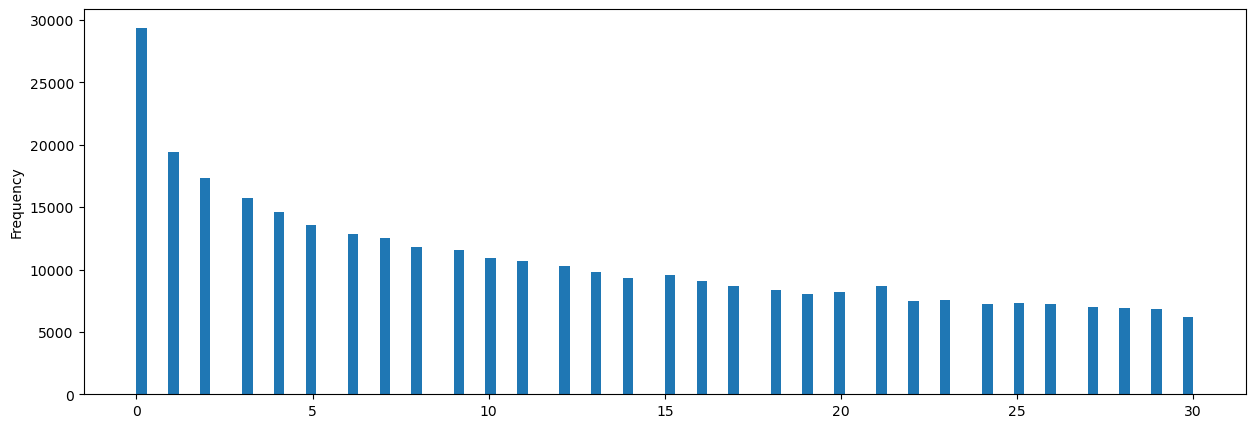

In [10]:
predictions_for_cold_start_users['num_predictions'].plot(kind='hist', bins=100, range=(0, 30), figsize=(15, 5))

In [11]:
predictions_for_cold_start_users[predictions_for_cold_start_users.num_predictions > 5].count()

session                   2455209
aid                       2455209
type                      2455209
aids_for_cold_aid_real    2455209
session_type              2455209
flag                      2455209
num_predictions           2455209
dtype: int64

## 2.Ensembling

### 2.1First approach
Ensembling the last session predictions with the all session predictions + cold start users

#### 2.1.1 Predictions from past history

In [12]:
predictions_history = predictions_history_last_session.merge(predictions_history_all_session, on='session', how='left')
predictions_history.head()

,session,prediction_last_session_0,prediction_last_session_1,prediction_last_session_2,prediction_all_session_0,prediction_all_session_1,prediction_all_session_2
0,12899779,[59625],[],[],[59625],[],[]
1,12899780,"[1142000, 736515, 973453, 582732]",[],[],"[1142000, 736515, 973453, 582732]",[],[]
2,12899781,"[918667, 199008]",[],[],"[918667, 199008, 194067, 57315, 141736]",[199008],[]
3,12899782,"[740494, 229748, 530899, 1072927, 638410, 987399, 1099390, 889671, 834354, 406001, 975116, 476063, 723956, 654809, 829180, 363336, 794259, 1344773, 1352725]","[834354, 740494, 987399, 889671, 127404, 1711180, 1344773]","[1007613, 595994, 1033148, 834354, 479970, 1696036, 829180, 1669402]","[740494, 229748, 530899, 1072927, 638410, 987399, 1099390, 889671, 834354, 406001, 975116, 476063, 723956, 654809, 829180, 363336, 794259, 1344773, 1352725, 1299062, 595994, 779477, 562753, 1037537, 413962, 603159, 45034, 1596098, 602722, 1674681, 1494780, 1669402]","[834354, 740494, 987399, 889671, 127404, 1711180, 1344773, 595994, 975116, 779477, 476063, 562753, 413962, 1494780]","[1007613, 595994, 1033148, 834354, 479970, 1696036, 829180, 1669402]"
4,12899783,[1817895],[],[],"[1817895, 607638, 1754419, 1216820, 1729553, 300127, 198385, 255297, 1114789]",[],[]


In [13]:
predictions_history["prediction_combined"] = predictions_history.apply(
    lambda row: [
        *row.prediction_last_session_2,
        *row.prediction_last_session_1,
        *row.prediction_last_session_0,
        *row.prediction_all_session_2,
        *row.prediction_all_session_1,
        *row.prediction_all_session_0,
    ],
    axis=1,
)
predictions_history.head()

,session,prediction_last_session_0,prediction_last_session_1,prediction_last_session_2,prediction_all_session_0,prediction_all_session_1,prediction_all_session_2,prediction_combined
0,12899779,[59625],[],[],[59625],[],[],"[59625, 59625]"
1,12899780,"[1142000, 736515, 973453, 582732]",[],[],"[1142000, 736515, 973453, 582732]",[],[],"[1142000, 736515, 973453, 582732, 1142000, 736515, 973453, 582732]"
2,12899781,"[918667, 199008]",[],[],"[918667, 199008, 194067, 57315, 141736]",[199008],[],"[918667, 199008, 199008, 918667, 199008, 194067, 57315, 141736]"
3,12899782,"[740494, 229748, 530899, 1072927, 638410, 987399, 1099390, 889671, 834354, 406001, 975116, 476063, 723956, 654809, 829180, 363336, 794259, 1344773, 1352725]","[834354, 740494, 987399, 889671, 127404, 1711180, 1344773]","[1007613, 595994, 1033148, 834354, 479970, 1696036, 829180, 1669402]","[740494, 229748, 530899, 1072927, 638410, 987399, 1099390, 889671, 834354, 406001, 975116, 476063, 723956, 654809, 829180, 363336, 794259, 1344773, 1352725, 1299062, 595994, 779477, 562753, 1037537, 413962, 603159, 45034, 1596098, 602722, 1674681, 1494780, 1669402]","[834354, 740494, 987399, 889671, 127404, 1711180, 1344773, 595994, 975116, 779477, 476063, 562753, 413962, 1494780]","[1007613, 595994, 1033148, 834354, 479970, 1696036, 829180, 1669402]","[1007613, 595994, 1033148, 834354, 479970, 1696036, 829180, 1669402, 834354, 740494, 987399, 889671, 127404, 1711180, 1344773, 740494, 229748, 530899, 1072927, 638410, 987399, 1099390, 889671, 834354, 406001, 975116, 476063, 723956, 654809, 829180, 363336, 794259, 1344773, 1352725, 1007613, 595994, 1033148, 834354, 479970, 1696036, 829180, 1669402, 834354, 740494, 987399, 889671, 127404, 1711180, 1344773, 595994, 975116, 779477, 476063, 562753, 413962, 1494780, 740494, 229748, 530899, 1072927, 638410, 987399, 1099390, 889671, 834354, 406001, 975116, 476063, 723956, 654809, 829180, 363336, 794259, 1344773, 1352725, 1299062, 595994, 779477, 562753, 1037537, 413962, 603159, 45034, 1596098, 602722, 1674681, 1494780, 1669402]"
4,12899783,[1817895],[],[],"[1817895, 607638, 1754419, 1216820, 1729553, 300127, 198385, 255297, 1114789]",[],[],"[1817895, 1817895, 607638, 1754419, 1216820, 1729553, 300127, 198385, 255297, 1114789]"


In [14]:
#drop duplicates predictions
predictions_history["prediction_combined_uniq"] = predictions_history["prediction_combined"].apply(lambda x: list(dict.fromkeys(x)))
predictions_history.head()

,session,prediction_last_session_0,prediction_last_session_1,prediction_last_session_2,prediction_all_session_0,prediction_all_session_1,prediction_all_session_2,prediction_combined,prediction_combined_uniq
0,12899779,[59625],[],[],[59625],[],[],"[59625, 59625]",[59625]
1,12899780,"[1142000, 736515, 973453, 582732]",[],[],"[1142000, 736515, 973453, 582732]",[],[],"[1142000, 736515, 973453, 582732, 1142000, 736515, 973453, 582732]","[1142000, 736515, 973453, 582732]"
2,12899781,"[918667, 199008]",[],[],"[918667, 199008, 194067, 57315, 141736]",[199008],[],"[918667, 199008, 199008, 918667, 199008, 194067, 57315, 141736]","[918667, 199008, 194067, 57315, 141736]"
3,12899782,"[740494, 229748, 530899, 1072927, 638410, 987399, 1099390, 889671, 834354, 406001, 975116, 476063, 723956, 654809, 829180, 363336, 794259, 1344773, 1352725]","[834354, 740494, 987399, 889671, 127404, 1711180, 1344773]","[1007613, 595994, 1033148, 834354, 479970, 1696036, 829180, 1669402]","[740494, 229748, 530899, 1072927, 638410, 987399, 1099390, 889671, 834354, 406001, 975116, 476063, 723956, 654809, 829180, 363336, 794259, 1344773, 1352725, 1299062, 595994, 779477, 562753, 1037537, 413962, 603159, 45034, 1596098, 602722, 1674681, 1494780, 1669402]","[834354, 740494, 987399, 889671, 127404, 1711180, 1344773, 595994, 975116, 779477, 476063, 562753, 413962, 1494780]","[1007613, 595994, 1033148, 834354, 479970, 1696036, 829180, 1669402]","[1007613, 595994, 1033148, 834354, 479970, 1696036, 829180, 1669402, 834354, 740494, 987399, 889671, 127404, 1711180, 1344773, 740494, 229748, 530899, 1072927, 638410, 987399, 1099390, 889671, 834354, 406001, 975116, 476063, 723956, 654809, 829180, 363336, 794259, 1344773, 1352725, 1007613, 595994, 1033148, 834354, 479970, 1696036, 829180, 1669402, 834354, 740494, 987399, 889671, 127404, 1711180, 1344773, 595994, 975116, 779477, 476063, 562753, 413962, 1494780, 740494, 229748, 530899, 1072927, 638410, 987399, 1099390, 889671, 834354, 406001, 975116, 476063, 723956, 654809, 829180, 363336, 794259, 1344773, 1352725, 1299062, 595994, 779477, 562753, 1037537, 413962, 603159, 45034, 1596098, 602722, 1674681, 1494780, 1669402]","[1007613, 595994, 1033148, 834354, 479970, 1696036, 829180, 1669402, 740494, 987399, 889671, 127404, 1711180, 1344773, 229748, 530899, 1072927, 638410, 1099390, 406001, 975116, 476063, 723956, 654809, 363336, 794259, 1352725, 779477, 562753, 413962, 1494780, 1299062, 1037537, 603159, 45034, 1596098, 602722, 1674681]"
4,12899783,[1817895],[],[],"[1817895, 607638, 1754419, 1216820, 1729553, 300127, 198385, 255297, 1114789]",[],[],"[1817895, 1817895, 607638, 1754419, 1216820, 1729553, 300127, 198385, 255297, 1114789]","[1817895, 607638, 1754419, 1216820, 1729553, 300127, 198385, 255297, 1114789]"


In [15]:
predictions_history.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1671803 entries, 0 to 1671802
Data columns (total 9 columns):
 #   Column                     Non-Null Count    Dtype 
---  ------                     --------------    ----- 
 0   session                    1671803 non-null  int64 
 1   prediction_last_session_0  1671803 non-null  object
 2   prediction_last_session_1  1671803 non-null  object
 3   prediction_last_session_2  1671803 non-null  object
 4   prediction_all_session_0   1671803 non-null  object
 5   prediction_all_session_1   1671803 non-null  object
 6   prediction_all_session_2   1671803 non-null  object
 7   prediction_combined        1671803 non-null  object
 8   prediction_combined_uniq   1671803 non-null  object
dtypes: int64(1), object(8)
memory usage: 127.5+ MB


In [16]:
predictions_history["num_predictions"] = predictions_history[
    "prediction_combined_uniq"
].apply(lambda x: len(x))



<AxesSubplot:ylabel='Frequency'>

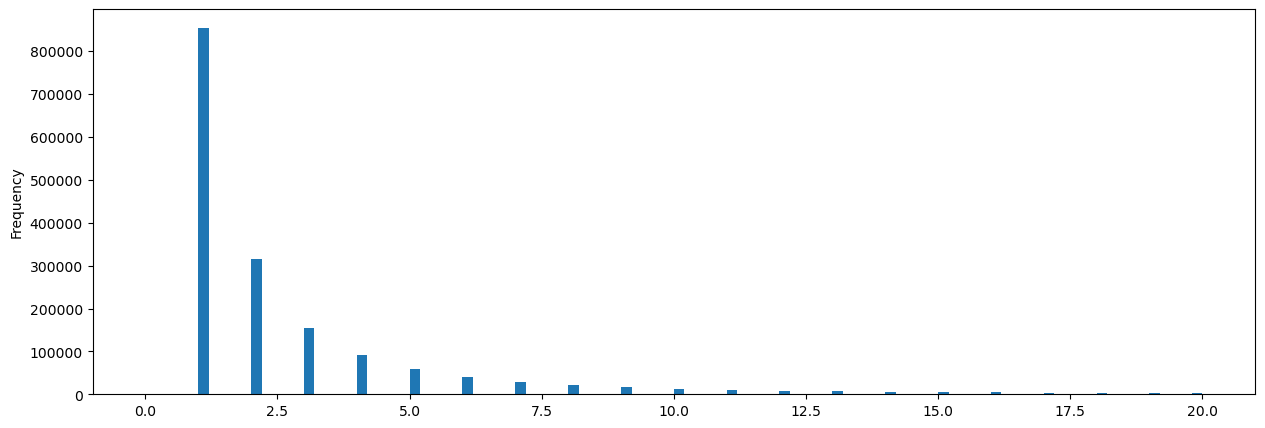

In [17]:
predictions_history['num_predictions'].plot(kind='hist', bins=100, range=(0, 20), figsize=(15, 5))

In [18]:
predictions_history[predictions_history.num_predictions >5].count()

session                      196140
prediction_last_session_0    196140
prediction_last_session_1    196140
prediction_last_session_2    196140
prediction_all_session_0     196140
prediction_all_session_1     196140
prediction_all_session_2     196140
prediction_combined          196140
prediction_combined_uniq     196140
num_predictions              196140
dtype: int64

In [19]:
predictions_history_clicks = predictions_history.copy()
predictions_history_carts = predictions_history.copy()
predictions_history_orders = predictions_history.copy()


In [20]:
predictions_history_clicks['session_type'] = predictions_history['session'].apply(lambda x: str(x) + '_clicks')
predictions_history_carts['session_type'] = predictions_history['session'].apply(lambda x: str(x) + '_carts')
predictions_history_orders['session_type'] = predictions_history['session'].apply(lambda x: str(x) + '_orders')
predictions_history_carts.head()

,session,prediction_last_session_0,prediction_last_session_1,prediction_last_session_2,prediction_all_session_0,prediction_all_session_1,prediction_all_session_2,prediction_combined,prediction_combined_uniq,num_predictions,session_type
0,12899779,[59625],[],[],[59625],[],[],"[59625, 59625]",[59625],1,12899779_carts
1,12899780,"[1142000, 736515, 973453, 582732]",[],[],"[1142000, 736515, 973453, 582732]",[],[],"[1142000, 736515, 973453, 582732, 1142000, 736515, 973453, 582732]","[1142000, 736515, 973453, 582732]",4,12899780_carts
2,12899781,"[918667, 199008]",[],[],"[918667, 199008, 194067, 57315, 141736]",[199008],[],"[918667, 199008, 199008, 918667, 199008, 194067, 57315, 141736]","[918667, 199008, 194067, 57315, 141736]",5,12899781_carts
3,12899782,"[740494, 229748, 530899, 1072927, 638410, 987399, 1099390, 889671, 834354, 406001, 975116, 476063, 723956, 654809, 829180, 363336, 794259, 1344773, 1352725]","[834354, 740494, 987399, 889671, 127404, 1711180, 1344773]","[1007613, 595994, 1033148, 834354, 479970, 1696036, 829180, 1669402]","[740494, 229748, 530899, 1072927, 638410, 987399, 1099390, 889671, 834354, 406001, 975116, 476063, 723956, 654809, 829180, 363336, 794259, 1344773, 1352725, 1299062, 595994, 779477, 562753, 1037537, 413962, 603159, 45034, 1596098, 602722, 1674681, 1494780, 1669402]","[834354, 740494, 987399, 889671, 127404, 1711180, 1344773, 595994, 975116, 779477, 476063, 562753, 413962, 1494780]","[1007613, 595994, 1033148, 834354, 479970, 1696036, 829180, 1669402]","[1007613, 595994, 1033148, 834354, 479970, 1696036, 829180, 1669402, 834354, 740494, 987399, 889671, 127404, 1711180, 1344773, 740494, 229748, 530899, 1072927, 638410, 987399, 1099390, 889671, 834354, 406001, 975116, 476063, 723956, 654809, 829180, 363336, 794259, 1344773, 1352725, 1007613, 595994, 1033148, 834354, 479970, 1696036, 829180, 1669402, 834354, 740494, 987399, 889671, 127404, 1711180, 1344773, 595994, 975116, 779477, 476063, 562753, 413962, 1494780, 740494, 229748, 530899, 1072927, 638410, 987399, 1099390, 889671, 834354, 406001, 975116, 476063, 723956, 654809, 829180, 363336, 794259, 1344773, 1352725, 1299062, 595994, 779477, 562753, 1037537, 413962, 603159, 45034, 1596098, 602722, 1674681, 1494780, 1669402]","[1007613, 595994, 1033148, 834354, 479970, 1696036, 829180, 1669402, 740494, 987399, 889671, 127404, 1711180, 1344773, 229748, 530899, 1072927, 638410, 1099390, 406001, 975116, 476063, 723956, 654809, 363336, 794259, 1352725, 779477, 562753, 413962, 1494780, 1299062, 1037537, 603159, 45034, 1596098, 602722, 1674681]",38,12899782_carts
4,12899783,[1817895],[],[],"[1817895, 607638, 1754419, 1216820, 1729553, 300127, 198385, 255297, 1114789]",[],[],"[1817895, 1817895, 607638, 1754419, 1216820, 1729553, 300127, 198385, 255297, 1114789]","[1817895, 607638, 1754419, 1216820, 1729553, 300127, 198385, 255297, 1114789]",9,12899783_carts


In [21]:
predictions_history_all = pd.concat(
    [predictions_history_clicks, predictions_history_carts, predictions_history_orders],
    axis=0,
    ignore_index=True,
)[["session_type", "prediction_combined_uniq"]]
predictions_history_all.head()

,session_type,prediction_combined_uniq
0,12899779_clicks,[59625]
1,12899780_clicks,"[1142000, 736515, 973453, 582732]"
2,12899781_clicks,"[918667, 199008, 194067, 57315, 141736]"
3,12899782_clicks,"[1007613, 595994, 1033148, 834354, 479970, 1696036, 829180, 1669402, 740494, 987399, 889671, 127404, 1711180, 1344773, 229748, 530899, 1072927, 638410, 1099390, 406001, 975116, 476063, 723956, 654809, 363336, 794259, 1352725, 779477, 562753, 413962, 1494780, 1299062, 1037537, 603159, 45034, 1596098, 602722, 1674681]"
4,12899783_clicks,"[1817895, 607638, 1754419, 1216820, 1729553, 300127, 198385, 255297, 1114789]"


In [22]:
predictions_history_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5015409 entries, 0 to 5015408
Data columns (total 2 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   session_type              object
 1   prediction_combined_uniq  object
dtypes: object(2)
memory usage: 76.5+ MB


#### 2.1.2 Predictions from cold start users

In [23]:
predictions_for_cold_start_users.head()

,session,aid,type,aids_for_cold_aid_real,session_type,flag,num_predictions
839607,12899779,59625,1,"[469285, 251302, 1130911, 1657590, 397451, 1493965, 689970, 1491271, 435875, 920960]",12899779_carts,1,10
0,12899779,59625,0,"[59625, 737445, 438191, 1340695, 731692, 1253524, 941596, 1790770, 448688, 1667087, 475447, 1265085, 707616, 94230, 620510, 1138236, 1817286, 1415576, 967363, 273918, 707499, 1700255, 1081608, 1103941, 894169, 199422, 339846, 1422133, 1660529, 758199, 1202618, 697340, 1695265, 89997, 658421, 1491271, 435875, 370533, 1163588, 1410719, 1631559, 1014952, 920960, 425824, 1589312, 1582154, 1774847, 381972, 1852616, 535538, 1159379, 1630830, 1224704, 1464625, 1854220, 1072236, 1718550, 1545861, 581388, 1336097, 1034093, 1288826, 146176, 1031677, 973193, 1349921, 378851, 1149867, 387026, 1517085, 1204217, 225209, 984047, 830629, 499621, 1019683, 45290, 164098, 523135, 811662, 3295, 1505323, 1854910, 1606540, 985764, 637538, 535414, 361861, 679602, 790748, 849637, 687865, 718440, 1481388, 286535, 1804863, 302827, 1153899, 729915, 578742]",12899779_clicks,0,100
1679214,12899779,59625,2,[],12899779_orders,1,0
839608,12899786,955252,1,"[955252, 1792771, 1593281, 1309503, 1348058, 28674, 997720, 940465, 1563147, 453267, 1149933, 1203425, 491200, 110579, 1840048, 678882, 543690, 852817, 554230, 1186873, 715146, 1245357, 1743402, 1615354, 108357, 1598882, 1855219, 908007, 1073616, 1218809]",12899786_carts,0,30
1,12899786,955252,0,"[955252, 1632910, 554230, 98930, 1853605, 1792771, 1186873, 1218809, 962766, 1207659, 302745, 15983, 1250405, 1840048, 90173, 1736098, 543690, 940465, 777554, 28674, 213691, 152132, 908492, 1082228, 1593281, 1610349, 1320155, 1458791, 1687558, 679967, 1699291, 691417, 1644889, 285480, 28104, 1560710, 1442051, 1369591, 981872, 1348058, 81857, 853993, 491200, 1203425, 150533, 1149933, 453267, 1599889, 833245, 1555393, 570054, 1299839, 1014923, 794192, 59455, 1580498, 656475, 26525, 1263666, 606395, 518311, 1488154, 275725, 561063, 350891, 522206, 1563147, 136152, 815935, 997720, 1766301, 1797516, 1749694, 1679772, 678882, 1470301, 441090, 814450, 1460239, 1362711, 191012, 336903, 1395262, 1558673, 691777, 146256, 1600810, 1635094, 110579, 674494, 728700, 1036074, 438233, 1215103, 852817, 1255670, 318358, 908007, 1073616, 1855219]",12899786_clicks,0,100


In [24]:
unique_sessions_list = predictions_for_cold_start_users['session'].unique().tolist()
unique_sessions_list[:5]

[12899779, 12899786, 12899796, 12899800, 12899804]

In [25]:
'''aids_cold_start = []

for session in tqdm(unique_sessions_list):
    df = predictions_for_cold_start_users[
        predictions_for_cold_start_users.session == session
    ]
    aids_clicks = df[df.type == 0]["aids_for_cold_aid_real"].to_list()[0]
    aids_carts = df[df.type == 1]["aids_for_cold_aid_real"].to_list()[0]
    aids_orders = df[df.type == 2]["aids_for_cold_aid_real"].to_list()[0]
    aids_all = np.concatenate((aids_orders, aids_carts, aids_clicks))
    aids_cold_start.append(aids_all)

predictions_for_cold_start_users_new = pd.DataFrame(
    {"session": unique_sessions_list, "aids_cold_start": aids_cold_start}
)
predictions_for_cold_start_users_new.head()'''

'aids_cold_start = []\n\nfor session in tqdm(unique_sessions_list):\n    df = predictions_for_cold_start_users[\n        predictions_for_cold_start_users.session == session\n    ]\n    aids_clicks = df[df.type == 0]["aids_for_cold_aid_real"].to_list()[0]\n    aids_carts = df[df.type == 1]["aids_for_cold_aid_real"].to_list()[0]\n    aids_orders = df[df.type == 2]["aids_for_cold_aid_real"].to_list()[0]\n    aids_all = np.concatenate((aids_orders, aids_carts, aids_clicks))\n    aids_cold_start.append(aids_all)\n\npredictions_for_cold_start_users_new = pd.DataFrame(\n    {"session": unique_sessions_list, "aids_cold_start": aids_cold_start}\n)\npredictions_for_cold_start_users_new.head()'

In [26]:
# make the same predictions for clicks, carts and orders
'''predictions_for_cold_start_users_new_clicks = predictions_for_cold_start_users_new.copy()
predictions_for_cold_start_users_new_carts = predictions_for_cold_start_users_new.copy()
predictions_for_cold_start_users_new_orders = predictions_for_cold_start_users_new.copy()

predictions_for_cold_start_users_new_clicks[
    "session"
] = predictions_for_cold_start_users_new_clicks["session"].apply(
    lambda x: str(x) + "_clicks"
)
predictions_for_cold_start_users_new_carts[
    "session"
] = predictions_for_cold_start_users_new_carts["session"].apply(
    lambda x: str(x) + "_carts"
)
predictions_for_cold_start_users_new_orders[
    "session"
] = predictions_for_cold_start_users_new_orders["session"].apply(
    lambda x: str(x) + "_orders"
)

predictions_for_cold_start_users_new_full = pd.concat(
    [
        predictions_for_cold_start_users_new_clicks,
        predictions_for_cold_start_users_new_carts,
        predictions_for_cold_start_users_new_orders,
    ],
    axis=0,
    ignore_index=True,
)[["session", "aids_cold_start"]]

predictions_for_cold_start_users_new_full = (
    predictions_for_cold_start_users_new_full.rename(
        columns={"session": "session_type", "aids_cold_start": "aids_for_cold_aid_real"}
    )
)
predictions_for_cold_start_users_new_full.head()'''

'predictions_for_cold_start_users_new_clicks = predictions_for_cold_start_users_new.copy()\npredictions_for_cold_start_users_new_carts = predictions_for_cold_start_users_new.copy()\npredictions_for_cold_start_users_new_orders = predictions_for_cold_start_users_new.copy()\n\npredictions_for_cold_start_users_new_clicks[\n    "session"\n] = predictions_for_cold_start_users_new_clicks["session"].apply(\n    lambda x: str(x) + "_clicks"\n)\npredictions_for_cold_start_users_new_carts[\n    "session"\n] = predictions_for_cold_start_users_new_carts["session"].apply(\n    lambda x: str(x) + "_carts"\n)\npredictions_for_cold_start_users_new_orders[\n    "session"\n] = predictions_for_cold_start_users_new_orders["session"].apply(\n    lambda x: str(x) + "_orders"\n)\n\npredictions_for_cold_start_users_new_full = pd.concat(\n    [\n        predictions_for_cold_start_users_new_clicks,\n        predictions_for_cold_start_users_new_carts,\n        predictions_for_cold_start_users_new_orders,\n    ],\

In [27]:
predictions_for_cold_start_users_new_full = pd.read_parquet('/Users/Artem_Boltaev/Documents/EPAM Projects/7. RecSys_OTTO_Kaggle/source_code/otto_recsys_kaggle/data/processed/predictions_for_cold_start_users_merged.parquet')

In [28]:
predictions_for_cold_start_users_new_full[
    "aids_for_cold_aid_real"
] = predictions_for_cold_start_users_new_full["aids_for_cold_aid_real"].apply(
    lambda x: x[:40]
)

In [29]:
#predictions_for_cold_start_users_new_full.to_parquet(
#    "/Users/Artem_Boltaev/Documents/EPAM Projects/7. RecSys_OTTO_Kaggle/source_code/otto_recsys_kaggle/data/processed/predictions_for_cold_start_users_merged.parquet")

In [30]:
predictions_for_cold_start_users_new_full[predictions_for_cold_start_users_new_full.session_type == '12900769_clicks']

,session_type,aids_for_cold_aid_real
396,12900769_clicks,"[1567663, 1567663, 1308159, 728774, 296943, 1506603, 196361, 420017, 852030, 177216, 110666, 1575551, 196715, 1477997, 560629, 1115063, 1111933, 812976, 738242, 1427111, 1292754, 1221950, 304839, 980637, 1789194, 775694, 1287365, 331708, 518425, 1458224, 1299205, 709657, 572308, 1334308]"


#### 2.1.3 Predictions from past history + predictions for cold start users

In [31]:
predictions_history_all = predictions_history_all.merge(predictions_for_cold_start_users_new_full, on='session_type', how='left')
predictions_history_all.head(20)

,session_type,prediction_combined_uniq,aids_for_cold_aid_real
0,12899779_clicks,[59625],"[469285, 251302, 1130911, 1657590, 397451, 1493965, 689970, 1491271, 435875, 920960, 59625, 737445, 438191, 1340695, 731692, 1253524, 941596, 1790770, 448688, 1667087, 475447, 1265085, 707616, 94230, 620510, 1138236, 1817286, 1415576, 967363, 273918, 707499, 1700255, 1081608, 1103941, 894169, 199422, 339846, 1422133, 1660529, 758199]"
1,12899780_clicks,"[1142000, 736515, 973453, 582732]",NaN
2,12899781_clicks,"[918667, 199008, 194067, 57315, 141736]",NaN
3,12899782_clicks,"[1007613, 595994, 1033148, 834354, 479970, 1696036, 829180, 1669402, 740494, 987399, 889671, 127404, 1711180, 1344773, 229748, 530899, 1072927, 638410, 1099390, 406001, 975116, 476063, 723956, 654809, 363336, 794259, 1352725, 779477, 562753, 413962, 1494780, 1299062, 1037537, 603159, 45034, 1596098, 602722, 1674681]",NaN
4,12899783_clicks,"[1817895, 607638, 1754419, 1216820, 1729553, 300127, 198385, 255297, 1114789]",NaN
5,12899784_clicks,"[1190477, 22981, 1546830, 1579935, 476216, 1269952, 1036375]",NaN
6,12899785_clicks,"[1497876, 775584, 1179870, 453905, 258458, 383003, 160666, 41655, 1433061, 614626, 804799, 253080, 874493, 1397811, 219032, 1008570, 1784451, 1308865, 656708, 1169631, 10851, 1553332, 543919, 1071379, 552698, 1259418, 1154962, 587969, 51772, 903397, 544238, 1254866, 1444536, 179800, 95259, 608210, 970225]",NaN
7,12899786_clicks,[955252],"[955252, 1792771, 105905, 766200, 108357, 715146, 1309503, 1563147, 955252, 1792771, 1593281, 1309503, 1348058, 28674, 997720, 940465, 1563147, 453267, 1149933, 1203425, 491200, 110579, 1840048, 678882, 543690, 852817, 554230, 1186873, 715146, 1245357, 1743402, 1615354, 108357, 1598882, 1855219, 908007, 1073616, 1218809, 955252, 1632910]"
8,12899787_clicks,"[1682750, 1024433]",NaN
9,12899788_clicks,"[1663048, 1259911, 39846, 245131]",NaN


In [32]:
predictions_history_all[predictions_history_all.session_type == '12900769_orders']

,session_type,prediction_combined_uniq,aids_for_cold_aid_real
3344596,12900769_orders,[1567663],"[1567663, 1567663, 1308159, 728774, 296943, 1506603, 196361, 420017, 852030, 177216, 110666, 1575551, 196715, 1477997, 560629, 1115063, 1111933, 812976, 738242, 1427111, 1292754, 1221950, 304839, 980637, 1789194, 775694, 1287365, 331708, 518425, 1458224, 1299205, 709657, 572308, 1334308]"


In [33]:
# fill nan values with empty list
for row in predictions_history_all.loc[
    predictions_history_all.aids_for_cold_aid_real.isnull(), "aids_for_cold_aid_real"
].index:
    predictions_history_all.at[row, "aids_for_cold_aid_real"] = []

predictions_history_all.head()

,session_type,prediction_combined_uniq,aids_for_cold_aid_real
0,12899779_clicks,[59625],"[469285, 251302, 1130911, 1657590, 397451, 1493965, 689970, 1491271, 435875, 920960, 59625, 737445, 438191, 1340695, 731692, 1253524, 941596, 1790770, 448688, 1667087, 475447, 1265085, 707616, 94230, 620510, 1138236, 1817286, 1415576, 967363, 273918, 707499, 1700255, 1081608, 1103941, 894169, 199422, 339846, 1422133, 1660529, 758199]"
1,12899780_clicks,"[1142000, 736515, 973453, 582732]",[]
2,12899781_clicks,"[918667, 199008, 194067, 57315, 141736]",[]
3,12899782_clicks,"[1007613, 595994, 1033148, 834354, 479970, 1696036, 829180, 1669402, 740494, 987399, 889671, 127404, 1711180, 1344773, 229748, 530899, 1072927, 638410, 1099390, 406001, 975116, 476063, 723956, 654809, 363336, 794259, 1352725, 779477, 562753, 413962, 1494780, 1299062, 1037537, 603159, 45034, 1596098, 602722, 1674681]",[]
4,12899783_clicks,"[1817895, 607638, 1754419, 1216820, 1729553, 300127, 198385, 255297, 1114789]",[]


In [34]:
predictions_history_all["prediction_combined_hist_cold"] = predictions_history_all.apply(
    lambda row: [
        *row.prediction_combined_uniq,
        *row.aids_for_cold_aid_real,
    ],
    axis=1,
)
predictions_history_all.head()

,session_type,prediction_combined_uniq,aids_for_cold_aid_real,prediction_combined_hist_cold
0,12899779_clicks,[59625],"[469285, 251302, 1130911, 1657590, 397451, 1493965, 689970, 1491271, 435875, 920960, 59625, 737445, 438191, 1340695, 731692, 1253524, 941596, 1790770, 448688, 1667087, 475447, 1265085, 707616, 94230, 620510, 1138236, 1817286, 1415576, 967363, 273918, 707499, 1700255, 1081608, 1103941, 894169, 199422, 339846, 1422133, 1660529, 758199]","[59625, 469285, 251302, 1130911, 1657590, 397451, 1493965, 689970, 1491271, 435875, 920960, 59625, 737445, 438191, 1340695, 731692, 1253524, 941596, 1790770, 448688, 1667087, 475447, 1265085, 707616, 94230, 620510, 1138236, 1817286, 1415576, 967363, 273918, 707499, 1700255, 1081608, 1103941, 894169, 199422, 339846, 1422133, 1660529, 758199]"
1,12899780_clicks,"[1142000, 736515, 973453, 582732]",[],"[1142000, 736515, 973453, 582732]"
2,12899781_clicks,"[918667, 199008, 194067, 57315, 141736]",[],"[918667, 199008, 194067, 57315, 141736]"
3,12899782_clicks,"[1007613, 595994, 1033148, 834354, 479970, 1696036, 829180, 1669402, 740494, 987399, 889671, 127404, 1711180, 1344773, 229748, 530899, 1072927, 638410, 1099390, 406001, 975116, 476063, 723956, 654809, 363336, 794259, 1352725, 779477, 562753, 413962, 1494780, 1299062, 1037537, 603159, 45034, 1596098, 602722, 1674681]",[],"[1007613, 595994, 1033148, 834354, 479970, 1696036, 829180, 1669402, 740494, 987399, 889671, 127404, 1711180, 1344773, 229748, 530899, 1072927, 638410, 1099390, 406001, 975116, 476063, 723956, 654809, 363336, 794259, 1352725, 779477, 562753, 413962, 1494780, 1299062, 1037537, 603159, 45034, 1596098, 602722, 1674681]"
4,12899783_clicks,"[1817895, 607638, 1754419, 1216820, 1729553, 300127, 198385, 255297, 1114789]",[],"[1817895, 607638, 1754419, 1216820, 1729553, 300127, 198385, 255297, 1114789]"


In [35]:
# drop duplicates predictions
predictions_history_all["labels"] = predictions_history_all[
    "prediction_combined_hist_cold"
].apply(lambda x: list(dict.fromkeys(x)))
predictions_history_all.head()

,session_type,prediction_combined_uniq,aids_for_cold_aid_real,prediction_combined_hist_cold,labels
0,12899779_clicks,[59625],"[469285, 251302, 1130911, 1657590, 397451, 1493965, 689970, 1491271, 435875, 920960, 59625, 737445, 438191, 1340695, 731692, 1253524, 941596, 1790770, 448688, 1667087, 475447, 1265085, 707616, 94230, 620510, 1138236, 1817286, 1415576, 967363, 273918, 707499, 1700255, 1081608, 1103941, 894169, 199422, 339846, 1422133, 1660529, 758199]","[59625, 469285, 251302, 1130911, 1657590, 397451, 1493965, 689970, 1491271, 435875, 920960, 59625, 737445, 438191, 1340695, 731692, 1253524, 941596, 1790770, 448688, 1667087, 475447, 1265085, 707616, 94230, 620510, 1138236, 1817286, 1415576, 967363, 273918, 707499, 1700255, 1081608, 1103941, 894169, 199422, 339846, 1422133, 1660529, 758199]","[59625, 469285, 251302, 1130911, 1657590, 397451, 1493965, 689970, 1491271, 435875, 920960, 737445, 438191, 1340695, 731692, 1253524, 941596, 1790770, 448688, 1667087, 475447, 1265085, 707616, 94230, 620510, 1138236, 1817286, 1415576, 967363, 273918, 707499, 1700255, 1081608, 1103941, 894169, 199422, 339846, 1422133, 1660529, 758199]"
1,12899780_clicks,"[1142000, 736515, 973453, 582732]",[],"[1142000, 736515, 973453, 582732]","[1142000, 736515, 973453, 582732]"
2,12899781_clicks,"[918667, 199008, 194067, 57315, 141736]",[],"[918667, 199008, 194067, 57315, 141736]","[918667, 199008, 194067, 57315, 141736]"
3,12899782_clicks,"[1007613, 595994, 1033148, 834354, 479970, 1696036, 829180, 1669402, 740494, 987399, 889671, 127404, 1711180, 1344773, 229748, 530899, 1072927, 638410, 1099390, 406001, 975116, 476063, 723956, 654809, 363336, 794259, 1352725, 779477, 562753, 413962, 1494780, 1299062, 1037537, 603159, 45034, 1596098, 602722, 1674681]",[],"[1007613, 595994, 1033148, 834354, 479970, 1696036, 829180, 1669402, 740494, 987399, 889671, 127404, 1711180, 1344773, 229748, 530899, 1072927, 638410, 1099390, 406001, 975116, 476063, 723956, 654809, 363336, 794259, 1352725, 779477, 562753, 413962, 1494780, 1299062, 1037537, 603159, 45034, 1596098, 602722, 1674681]","[1007613, 595994, 1033148, 834354, 479970, 1696036, 829180, 1669402, 740494, 987399, 889671, 127404, 1711180, 1344773, 229748, 530899, 1072927, 638410, 1099390, 406001, 975116, 476063, 723956, 654809, 363336, 794259, 1352725, 779477, 562753, 413962, 1494780, 1299062, 1037537, 603159, 45034, 1596098, 602722, 1674681]"
4,12899783_clicks,"[1817895, 607638, 1754419, 1216820, 1729553, 300127, 198385, 255297, 1114789]",[],"[1817895, 607638, 1754419, 1216820, 1729553, 300127, 198385, 255297, 1114789]","[1817895, 607638, 1754419, 1216820, 1729553, 300127, 198385, 255297, 1114789]"


In [36]:
predictions_history_all['num_predictions'] = predictions_history_all['labels'].apply(lambda x: len(x))


<AxesSubplot:ylabel='Frequency'>

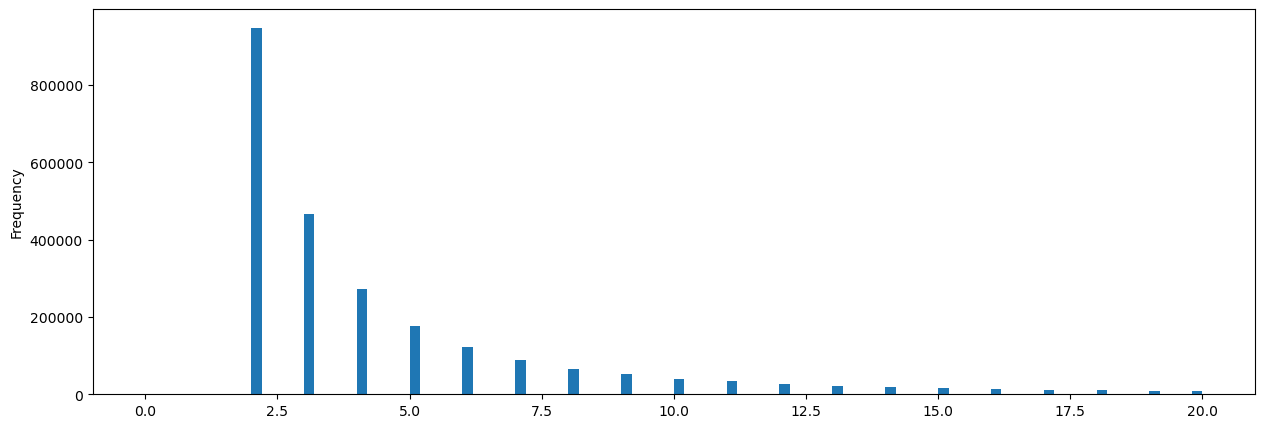

In [37]:
predictions_history_all['num_predictions'].plot(kind='hist', bins=100, range=(0, 20), figsize=(15, 5))

In [62]:
predictions_history_all[predictions_history_all.num_predictions == 3]

session_type                     465765
prediction_combined_uniq         465765
aids_for_cold_aid_real           465765
prediction_combined_hist_cold    465765
labels                           465765
num_predictions                  465765
dtype: int64

#### 2.1.4 Predictions for warm users from past history vstan

In [39]:
predictions_for_warm_users.head()

,session_type,labels
0,12899780_clicks,"[736515, 582732, 1142000, 1712906, 973453, 209046, 1735169, 1269469, 797055, 1586171, 409620, 889686, 487136, 432989, 346049, 215561, 625301, 1537673, 1758603, 1493044, 1502122, 1290032, 1032776, 830367, 119113, 636101, 760500, 298280, 1305442, 884502, 921561, 1383529, 455423, 1403849, 258814, 861045, 1125638, 1263108, 1773157, 1360606, 636813, 932551, 1684753, 1793976, 1419849, 1182614, 595830, 987426, 1358146, 460148, 756588, 874920, 1097576, 1570378, 1519088, 1754130, 837443, 600357, 19703, 64218, 719255, 1061164, 1681373, 1734061, 1517468, 1042751, 404612, 835647, 1202752, 1773744, 1787028, 231487, 1751849, 1717153, 236421, 1263747, 1153562, 502287, 322370, 521986, 1262640, 103974, 341480, 1752210, 1405784, 372942, 77422, 582375, 819422, 228037, 1179966, 1235182, 305418, 1660665, 1515511, 618310, 6172, 1344758, 1797399, 538616]"
1,12899781_clicks,"[918667, 199008, 1681537, 1628918, 1422724, 374037, 528496, 1836671, 1119163, 1495531, 515373, 600579, 89022, 1228668, 461608, 1102089, 1508281, 937784, 779172, 1022447, 752018, 428697, 3542, 842748, 257316, 759436, 1335672, 1467445, 811084, 1744908, 811448, 1008624, 1307153, 1842407, 1131549, 1334790, 950718, 1583317, 532314, 1446845, 1853288, 1200570, 273625, 747285, 1248748, 1722991, 1515266, 999262, 754412, 644935, 91240, 1460571, 1710337, 1242608, 55472, 316553, 349093, 1109824, 1835454, 1320174, 1006790, 141736, 1656929, 589670, 980990, 331708, 612096, 1043508, 820257, 1714342, 858072, 782161, 732299, 947961, 887053, 583237, 179219, 1655683, 1566487, 1310977, 1708360, 1790094, 869549, 1272792, 425177, 867018, 1144275, 205149, 1285766, 1590651, 1472402, 620508, 677903, 471005, 634452, 618888, 824574, 1750035, 1613425, 985169]"
2,12899782_clicks,"[1007613, 1033148, 383474, 595994, 479970, 1112446, 1523791, 1702672, 1727935, 1694535, 892387, 1779730, 1569170, 409367, 606309, 428633, 1522587, 968960, 846545, 752652, 1344564, 756913, 396198, 798152, 1501522, 365272, 605329, 669573, 410170, 652088, 223433, 1007094, 363001, 1657316, 950341, 670423, 1631509, 596104, 1302179, 238459, 717779, 1289327, 796572, 1476166, 448342, 910942, 1673439, 1829287, 150731, 1262244, 358986, 1032735, 1194702, 78262, 319580, 443797, 1408465, 911489, 1169987, 1465743, 815960, 573926, 1581293, 1447862, 1159782, 1170698, 1483494, 103757, 1839274, 1722334, 831653, 801774, 1780254, 555966, 873668, 1360636, 771362, 652098, 1807007, 1040793, 1445187, 705442, 1837818, 1586171, 831864, 74377, 1178150, 582323, 652897, 1758264, 386085, 898836, 170669, 322370, 920873, 606138, 1793059, 834354, 1228859, 14331]"
3,12899783_clicks,"[607638, 1754419, 1216820, 294573, 351665, 887179, 1420411, 1681696, 230028, 1734579, 379769, 354698, 384776, 1492009, 1317341, 544763, 1464627, 1249267, 697336, 998637, 1259202, 1654062, 936, 588923, 1257009, 1060039, 789476, 1387003, 1197907, 1158097, 217089, 1740051, 169050, 857375, 752196, 946317, 1553537, 1044960, 577040, 523174, 1349565, 511311, 1531080, 1773744, 228817, 1586171, 632990, 1494593, 463708, 1396148, 899991, 1726936, 1502122, 216491, 1390935, 10519, 325953, 187161, 1787028, 1157882, 935371, 137432, 657625, 520279, 62304, 1005116, 856427, 1392567, 1727436, 1032776, 125396, 623612, 987038, 258814, 1019327, 1823128, 141216, 205357, 428780, 854368, 1850770, 744715, 855613, 1451449, 1351549, 571762, 448755, 135833, 77422, 237592, 1769915, 1845169, 857504, 1052212, 1062554, 729476, 587327, 1719925, 134223, 226643]"
4,12899784_clicks,"[1190477, 1579935, 1546830, 22981, 476216, 655566, 988806, 1758193, 761536, 442293, 624476, 401010, 1187202, 228508, 292022, 29187, 707586, 910034, 584469, 1248272, 918094, 886762, 368335, 345189, 1770619, 1492404, 389800, 1269952, 487517, 712456, 482930, 1520313, 229155, 862939, 267082, 607439, 229362, 482711, 1390907, 1694129, 669719, 1268781, 37695, 450197, 1298590, 589191, 1449617, 389930, 1808377, 169403, 604331, 1841544, 707236, 346959, 1153393, 1672527, 1441150, 354904, 1137538, 1500911, 385496, 1436

#### 2.1.5 Merge all predictions

In [40]:
submission = predictions_history_all[['session_type', 'labels']].copy()
submission.head()

,session_type,labels
0,12899779_clicks,"[59625, 469285, 251302, 1130911, 1657590, 397451, 1493965, 689970, 1491271, 435875, 920960, 737445, 438191, 1340695, 731692, 1253524, 941596, 1790770, 448688, 1667087, 475447, 1265085, 707616, 94230, 620510, 1138236, 1817286, 1415576, 967363, 273918, 707499, 1700255, 1081608, 1103941, 894169, 199422, 339846, 1422133, 1660529, 758199]"
1,12899780_clicks,"[1142000, 736515, 973453, 582732]"
2,12899781_clicks,"[918667, 199008, 194067, 57315, 141736]"
3,12899782_clicks,"[1007613, 595994, 1033148, 834354, 479970, 1696036, 829180, 1669402, 740494, 987399, 889671, 127404, 1711180, 1344773, 229748, 530899, 1072927, 638410, 1099390, 406001, 975116, 476063, 723956, 654809, 363336, 794259, 1352725, 779477, 562753, 413962, 1494780, 1299062, 1037537, 603159, 45034, 1596098, 602722, 1674681]"
4,12899783_clicks,"[1817895, 607638, 1754419, 1216820, 1729553, 300127, 198385, 255297, 1114789]"


In [41]:
submission_new = submission.merge(predictions_for_warm_users, on='session_type', how='left')
submission_new.head()

,session_type,labels_x,labels_y
0,12899779_clicks,"[59625, 469285, 251302, 1130911, 1657590, 397451, 1493965, 689970, 1491271, 435875, 920960, 737445, 438191, 1340695, 731692, 1253524, 941596, 1790770, 448688, 1667087, 475447, 1265085, 707616, 94230, 620510, 1138236, 1817286, 1415576, 967363, 273918, 707499, 1700255, 1081608, 1103941, 894169, 199422, 339846, 1422133, 1660529, 758199]",NaN
1,12899780_clicks,"[1142000, 736515, 973453, 582732]","[736515, 582732, 1142000, 1712906, 973453, 209046, 1735169, 1269469, 797055, 1586171, 409620, 889686, 487136, 432989, 346049, 215561, 625301, 1537673, 1758603, 1493044, 1502122, 1290032, 1032776, 830367, 119113, 636101, 760500, 298280, 1305442, 884502, 921561, 1383529, 455423, 1403849, 258814, 861045, 1125638, 1263108, 1773157, 1360606, 636813, 932551, 1684753, 1793976, 1419849, 1182614, 595830, 987426, 1358146, 460148, 756588, 874920, 1097576, 1570378, 1519088, 1754130, 837443, 600357, 19703, 64218, 719255, 1061164, 1681373, 1734061, 1517468, 1042751, 404612, 835647, 1202752, 1773744, 1787028, 231487, 1751849, 1717153, 236421, 1263747, 1153562, 502287, 322370, 521986, 1262640, 103974, 341480, 1752210, 1405784, 372942, 77422, 582375, 819422, 228037, 1179966, 1235182, 305418, 1660665, 1515511, 618310, 6172, 1344758, 1797399, 538616]"
2,12899781_clicks,"[918667, 199008, 194067, 57315, 141736]","[918667, 199008, 1681537, 1628918, 1422724, 374037, 528496, 1836671, 1119163, 1495531, 515373, 600579, 89022, 1228668, 461608, 1102089, 1508281, 937784, 779172, 1022447, 752018, 428697, 3542, 842748, 257316, 759436, 1335672, 1467445, 811084, 1744908, 811448, 1008624, 1307153, 1842407, 1131549, 1334790, 950718, 1583317, 532314, 1446845, 1853288, 1200570, 273625, 747285, 1248748, 1722991, 1515266, 999262, 754412, 644935, 91240, 1460571, 1710337, 1242608, 55472, 316553, 349093, 1109824, 1835454, 1320174, 1006790, 141736, 1656929, 589670, 980990, 331708, 612096, 1043508, 820257, 1714342, 858072, 782161, 732299, 947961, 887053, 583237, 179219, 1655683, 1566487, 1310977, 1708360, 1790094, 869549, 1272792, 425177, 867018, 1144275, 205149, 1285766, 1590651, 1472402, 620508, 677903, 471005, 634452, 618888, 824574, 1750035, 1613425, 985169]"
3,12899782_clicks,"[1007613, 595994, 1033148, 834354, 479970, 1696036, 829180, 1669402, 740494, 987399, 889671, 127404, 1711180, 1344773, 229748, 530899, 1072927, 638410, 1099390, 406001, 975116, 476063, 723956, 654809, 363336, 794259, 1352725, 779477, 562753, 413962, 1494780, 1299062, 1037537, 603159, 45034, 1596098, 602722, 1674681]","[1007613, 1033148, 383474, 595994, 479970, 1112446, 1523791, 1702672, 1727935, 1694535, 892387, 1779730, 1569170, 409367, 606309, 428633, 1522587, 968960, 846545, 752652, 1344564, 756913, 396198, 798152, 1501522, 365272, 605329, 669573, 410170, 652088, 223433, 1007094, 363001, 1657316, 950341, 670423, 1631509, 596104, 1302179, 238459, 717779, 1289327, 796572, 1476166, 448342, 910942, 1673439, 1829287, 150731, 1262244, 358986, 1032735, 1194702, 78262, 319580, 443797, 1408465, 911489, 1169987, 1465743, 815960, 573926, 1581293, 1447862, 1159782, 1170698, 1483494, 103757, 1839274, 1722334, 831653, 801774, 1780254, 555966, 873668, 1360636, 771362, 652098, 1807007, 1040793, 1445187, 705442, 1837818, 1586171, 831864, 74377, 1178150, 582323, 652897, 1758264, 386085, 898836, 170669, 322370, 920873, 606138, 1793059, 834354, 1228859, 14331]"
4,12899783_clicks,"[1817895, 607638, 1754419, 1216820, 1729553, 300127, 198385, 255297, 1114789]","[607638, 1754419, 1216820, 294573, 351665, 887179, 1420411, 1681696, 230028, 1734579, 379769, 354698, 384776, 1492009, 1317341, 544763, 1464627, 1249267, 697336, 998637, 1259202, 1654062, 936, 588923, 1257009, 1060039, 789476, 1387003, 1197907, 1158097, 217089, 1740051, 169050, 857375, 752196, 946317, 1553537, 1044960, 577040, 523174, 1349565, 511311, 1531080, 1773744, 228817, 1586171, 632990, 1494593, 463708, 1396148, 899991, 1726936, 1502122, 216491, 1390935, 10519, 325953, 187161, 1787028, 1157882, 935371, 137432,

In [42]:
#fill nan values with empty list
for row in submission_new.loc[submission_new.labels_y.isnull(), 'labels_y'].index:
    submission_new.at[row, 'labels_y'] = []
submission_new.head()

,session_type,labels_x,labels_y
0,12899779_clicks,"[59625, 469285, 251302, 1130911, 1657590, 397451, 1493965, 689970, 1491271, 435875, 920960, 737445, 438191, 1340695, 731692, 1253524, 941596, 1790770, 448688, 1667087, 475447, 1265085, 707616, 94230, 620510, 1138236, 1817286, 1415576, 967363, 273918, 707499, 1700255, 1081608, 1103941, 894169, 199422, 339846, 1422133, 1660529, 758199]",[]
1,12899780_clicks,"[1142000, 736515, 973453, 582732]","[736515, 582732, 1142000, 1712906, 973453, 209046, 1735169, 1269469, 797055, 1586171, 409620, 889686, 487136, 432989, 346049, 215561, 625301, 1537673, 1758603, 1493044, 1502122, 1290032, 1032776, 830367, 119113, 636101, 760500, 298280, 1305442, 884502, 921561, 1383529, 455423, 1403849, 258814, 861045, 1125638, 1263108, 1773157, 1360606, 636813, 932551, 1684753, 1793976, 1419849, 1182614, 595830, 987426, 1358146, 460148, 756588, 874920, 1097576, 1570378, 1519088, 1754130, 837443, 600357, 19703, 64218, 719255, 1061164, 1681373, 1734061, 1517468, 1042751, 404612, 835647, 1202752, 1773744, 1787028, 231487, 1751849, 1717153, 236421, 1263747, 1153562, 502287, 322370, 521986, 1262640, 103974, 341480, 1752210, 1405784, 372942, 77422, 582375, 819422, 228037, 1179966, 1235182, 305418, 1660665, 1515511, 618310, 6172, 1344758, 1797399, 538616]"
2,12899781_clicks,"[918667, 199008, 194067, 57315, 141736]","[918667, 199008, 1681537, 1628918, 1422724, 374037, 528496, 1836671, 1119163, 1495531, 515373, 600579, 89022, 1228668, 461608, 1102089, 1508281, 937784, 779172, 1022447, 752018, 428697, 3542, 842748, 257316, 759436, 1335672, 1467445, 811084, 1744908, 811448, 1008624, 1307153, 1842407, 1131549, 1334790, 950718, 1583317, 532314, 1446845, 1853288, 1200570, 273625, 747285, 1248748, 1722991, 1515266, 999262, 754412, 644935, 91240, 1460571, 1710337, 1242608, 55472, 316553, 349093, 1109824, 1835454, 1320174, 1006790, 141736, 1656929, 589670, 980990, 331708, 612096, 1043508, 820257, 1714342, 858072, 782161, 732299, 947961, 887053, 583237, 179219, 1655683, 1566487, 1310977, 1708360, 1790094, 869549, 1272792, 425177, 867018, 1144275, 205149, 1285766, 1590651, 1472402, 620508, 677903, 471005, 634452, 618888, 824574, 1750035, 1613425, 985169]"
3,12899782_clicks,"[1007613, 595994, 1033148, 834354, 479970, 1696036, 829180, 1669402, 740494, 987399, 889671, 127404, 1711180, 1344773, 229748, 530899, 1072927, 638410, 1099390, 406001, 975116, 476063, 723956, 654809, 363336, 794259, 1352725, 779477, 562753, 413962, 1494780, 1299062, 1037537, 603159, 45034, 1596098, 602722, 1674681]","[1007613, 1033148, 383474, 595994, 479970, 1112446, 1523791, 1702672, 1727935, 1694535, 892387, 1779730, 1569170, 409367, 606309, 428633, 1522587, 968960, 846545, 752652, 1344564, 756913, 396198, 798152, 1501522, 365272, 605329, 669573, 410170, 652088, 223433, 1007094, 363001, 1657316, 950341, 670423, 1631509, 596104, 1302179, 238459, 717779, 1289327, 796572, 1476166, 448342, 910942, 1673439, 1829287, 150731, 1262244, 358986, 1032735, 1194702, 78262, 319580, 443797, 1408465, 911489, 1169987, 1465743, 815960, 573926, 1581293, 1447862, 1159782, 1170698, 1483494, 103757, 1839274, 1722334, 831653, 801774, 1780254, 555966, 873668, 1360636, 771362, 652098, 1807007, 1040793, 1445187, 705442, 1837818, 1586171, 831864, 74377, 1178150, 582323, 652897, 1758264, 386085, 898836, 170669, 322370, 920873, 606138, 1793059, 834354, 1228859, 14331]"
4,12899783_clicks,"[1817895, 607638, 1754419, 1216820, 1729553, 300127, 198385, 255297, 1114789]","[607638, 1754419, 1216820, 294573, 351665, 887179, 1420411, 1681696, 230028, 1734579, 379769, 354698, 384776, 1492009, 1317341, 544763, 1464627, 1249267, 697336, 998637, 1259202, 1654062, 936, 588923, 1257009, 1060039, 789476, 1387003, 1197907, 1158097, 217089, 1740051, 169050, 857375, 752196, 946317, 1553537, 1044960, 577040, 523174, 1349565, 511311, 1531080, 1773744, 228817, 1586171, 632990, 1494593, 463708, 1396148, 899991, 1726936, 1502122, 216491, 1390935, 10519, 325953, 187161, 1787028, 1157882, 935371, 137432, 

In [43]:
submission_new["labels"] = submission_new.apply(
    lambda row: [
        *row.labels_x,
        *row.labels_y,
    ],
    axis=1,
)
submission_new.head()

,session_type,labels_x,labels_y,labels
0,12899779_clicks,"[59625, 469285, 251302, 1130911, 1657590, 397451, 1493965, 689970, 1491271, 435875, 920960, 737445, 438191, 1340695, 731692, 1253524, 941596, 1790770, 448688, 1667087, 475447, 1265085, 707616, 94230, 620510, 1138236, 1817286, 1415576, 967363, 273918, 707499, 1700255, 1081608, 1103941, 894169, 199422, 339846, 1422133, 1660529, 758199]",[],"[59625, 469285, 251302, 1130911, 1657590, 397451, 1493965, 689970, 1491271, 435875, 920960, 737445, 438191, 1340695, 731692, 1253524, 941596, 1790770, 448688, 1667087, 475447, 1265085, 707616, 94230, 620510, 1138236, 1817286, 1415576, 967363, 273918, 707499, 1700255, 1081608, 1103941, 894169, 199422, 339846, 1422133, 1660529, 758199]"
1,12899780_clicks,"[1142000, 736515, 973453, 582732]","[736515, 582732, 1142000, 1712906, 973453, 209046, 1735169, 1269469, 797055, 1586171, 409620, 889686, 487136, 432989, 346049, 215561, 625301, 1537673, 1758603, 1493044, 1502122, 1290032, 1032776, 830367, 119113, 636101, 760500, 298280, 1305442, 884502, 921561, 1383529, 455423, 1403849, 258814, 861045, 1125638, 1263108, 1773157, 1360606, 636813, 932551, 1684753, 1793976, 1419849, 1182614, 595830, 987426, 1358146, 460148, 756588, 874920, 1097576, 1570378, 1519088, 1754130, 837443, 600357, 19703, 64218, 719255, 1061164, 1681373, 1734061, 1517468, 1042751, 404612, 835647, 1202752, 1773744, 1787028, 231487, 1751849, 1717153, 236421, 1263747, 1153562, 502287, 322370, 521986, 1262640, 103974, 341480, 1752210, 1405784, 372942, 77422, 582375, 819422, 228037, 1179966, 1235182, 305418, 1660665, 1515511, 618310, 6172, 1344758, 1797399, 538616]","[1142000, 736515, 973453, 582732, 736515, 582732, 1142000, 1712906, 973453, 209046, 1735169, 1269469, 797055, 1586171, 409620, 889686, 487136, 432989, 346049, 215561, 625301, 1537673, 1758603, 1493044, 1502122, 1290032, 1032776, 830367, 119113, 636101, 760500, 298280, 1305442, 884502, 921561, 1383529, 455423, 1403849, 258814, 861045, 1125638, 1263108, 1773157, 1360606, 636813, 932551, 1684753, 1793976, 1419849, 1182614, 595830, 987426, 1358146, 460148, 756588, 874920, 1097576, 1570378, 1519088, 1754130, 837443, 600357, 19703, 64218, 719255, 1061164, 1681373, 1734061, 1517468, 1042751, 404612, 835647, 1202752, 1773744, 1787028, 231487, 1751849, 1717153, 236421, 1263747, 1153562, 502287, 322370, 521986, 1262640, 103974, 341480, 1752210, 1405784, 372942, 77422, 582375, 819422, 228037, 1179966, 1235182, 305418, 1660665, 1515511, 618310, ...]"
2,12899781_clicks,"[918667, 199008, 194067, 57315, 141736]","[918667, 199008, 1681537, 1628918, 1422724, 374037, 528496, 1836671, 1119163, 1495531, 515373, 600579, 89022, 1228668, 461608, 1102089, 1508281, 937784, 779172, 1022447, 752018, 428697, 3542, 842748, 257316, 759436, 1335672, 1467445, 811084, 1744908, 811448, 1008624, 1307153, 1842407, 1131549, 1334790, 950718, 1583317, 532314, 1446845, 1853288, 1200570, 273625, 747285, 1248748, 1722991, 1515266, 999262, 754412, 644935, 91240, 1460571, 1710337, 1242608, 55472, 316553, 349093, 1109824, 1835454, 1320174, 1006790, 141736, 1656929, 589670, 980990, 331708, 612096, 1043508, 820257, 1714342, 858072, 782161, 732299, 947961, 887053, 583237, 179219, 1655683, 1566487, 1310977, 1708360, 1790094, 869549, 1272792, 425177, 867018, 1144275, 205149, 1285766, 1590651, 1472402, 620508, 677903, 471005, 634452, 618888, 824574, 1750035, 1613425, 985169]","[918667, 199008, 194067, 57315, 141736, 918667, 199008, 1681537, 1628918, 1422724, 374037, 528496, 1836671, 1119163, 1495531, 515373, 600579, 89022, 1228668, 461608, 1102089, 1508281, 937784, 779172, 1022447, 752018, 428697, 3542, 842748, 257316, 759436, 1335672, 1467445, 811084, 1744908, 811448, 1008624, 1307153, 1842407, 1131549, 1334790, 950718, 1583317, 532314, 1446845, 1853288, 1200570, 273625, 747285, 1248748, 1722991, 1515266, 999262, 754412, 644935, 91240, 1460571, 1710337, 1242608, 55472, 316553, 349093, 1109824, 1835454, 1320174, 1006790, 141736, 1656929, 589670, 980990, 331708, 612096, 10

In [44]:
# drop duplicates predictions
submission_new["labels"] = submission_new[
    "labels"
].apply(lambda x: list(dict.fromkeys(x)))

submission_new.head()

,session_type,labels_x,labels_y,labels
0,12899779_clicks,"[59625, 469285, 251302, 1130911, 1657590, 397451, 1493965, 689970, 1491271, 435875, 920960, 737445, 438191, 1340695, 731692, 1253524, 941596, 1790770, 448688, 1667087, 475447, 1265085, 707616, 94230, 620510, 1138236, 1817286, 1415576, 967363, 273918, 707499, 1700255, 1081608, 1103941, 894169, 199422, 339846, 1422133, 1660529, 758199]",[],"[59625, 469285, 251302, 1130911, 1657590, 397451, 1493965, 689970, 1491271, 435875, 920960, 737445, 438191, 1340695, 731692, 1253524, 941596, 1790770, 448688, 1667087, 475447, 1265085, 707616, 94230, 620510, 1138236, 1817286, 1415576, 967363, 273918, 707499, 1700255, 1081608, 1103941, 894169, 199422, 339846, 1422133, 1660529, 758199]"
1,12899780_clicks,"[1142000, 736515, 973453, 582732]","[736515, 582732, 1142000, 1712906, 973453, 209046, 1735169, 1269469, 797055, 1586171, 409620, 889686, 487136, 432989, 346049, 215561, 625301, 1537673, 1758603, 1493044, 1502122, 1290032, 1032776, 830367, 119113, 636101, 760500, 298280, 1305442, 884502, 921561, 1383529, 455423, 1403849, 258814, 861045, 1125638, 1263108, 1773157, 1360606, 636813, 932551, 1684753, 1793976, 1419849, 1182614, 595830, 987426, 1358146, 460148, 756588, 874920, 1097576, 1570378, 1519088, 1754130, 837443, 600357, 19703, 64218, 719255, 1061164, 1681373, 1734061, 1517468, 1042751, 404612, 835647, 1202752, 1773744, 1787028, 231487, 1751849, 1717153, 236421, 1263747, 1153562, 502287, 322370, 521986, 1262640, 103974, 341480, 1752210, 1405784, 372942, 77422, 582375, 819422, 228037, 1179966, 1235182, 305418, 1660665, 1515511, 618310, 6172, 1344758, 1797399, 538616]","[1142000, 736515, 973453, 582732, 1712906, 209046, 1735169, 1269469, 797055, 1586171, 409620, 889686, 487136, 432989, 346049, 215561, 625301, 1537673, 1758603, 1493044, 1502122, 1290032, 1032776, 830367, 119113, 636101, 760500, 298280, 1305442, 884502, 921561, 1383529, 455423, 1403849, 258814, 861045, 1125638, 1263108, 1773157, 1360606, 636813, 932551, 1684753, 1793976, 1419849, 1182614, 595830, 987426, 1358146, 460148, 756588, 874920, 1097576, 1570378, 1519088, 1754130, 837443, 600357, 19703, 64218, 719255, 1061164, 1681373, 1734061, 1517468, 1042751, 404612, 835647, 1202752, 1773744, 1787028, 231487, 1751849, 1717153, 236421, 1263747, 1153562, 502287, 322370, 521986, 1262640, 103974, 341480, 1752210, 1405784, 372942, 77422, 582375, 819422, 228037, 1179966, 1235182, 305418, 1660665, 1515511, 618310, 6172, 1344758, 1797399, 538616]"
2,12899781_clicks,"[918667, 199008, 194067, 57315, 141736]","[918667, 199008, 1681537, 1628918, 1422724, 374037, 528496, 1836671, 1119163, 1495531, 515373, 600579, 89022, 1228668, 461608, 1102089, 1508281, 937784, 779172, 1022447, 752018, 428697, 3542, 842748, 257316, 759436, 1335672, 1467445, 811084, 1744908, 811448, 1008624, 1307153, 1842407, 1131549, 1334790, 950718, 1583317, 532314, 1446845, 1853288, 1200570, 273625, 747285, 1248748, 1722991, 1515266, 999262, 754412, 644935, 91240, 1460571, 1710337, 1242608, 55472, 316553, 349093, 1109824, 1835454, 1320174, 1006790, 141736, 1656929, 589670, 980990, 331708, 612096, 1043508, 820257, 1714342, 858072, 782161, 732299, 947961, 887053, 583237, 179219, 1655683, 1566487, 1310977, 1708360, 1790094, 869549, 1272792, 425177, 867018, 1144275, 205149, 1285766, 1590651, 1472402, 620508, 677903, 471005, 634452, 618888, 824574, 1750035, 1613425, 985169]","[918667, 199008, 194067, 57315, 141736, 1681537, 1628918, 1422724, 374037, 528496, 1836671, 1119163, 1495531, 515373, 600579, 89022, 1228668, 461608, 1102089, 1508281, 937784, 779172, 1022447, 752018, 428697, 3542, 842748, 257316, 759436, 1335672, 1467445, 811084, 1744908, 811448, 1008624, 1307153, 1842407, 1131549, 1334790, 950718, 1583317, 532314, 1446845, 1853288, 1200570, 273625, 747285, 1248748, 1722991, 1515266, 999262, 754412, 644935, 91240, 1460571, 1710337, 1242608, 55472, 316553, 349093, 1109824, 1835454, 1320174, 1006790, 1656929, 589670, 980990, 331708, 612096, 1043508, 820257, 1714342, 858072

In [65]:
submission_new['num_predictions'] = submission_new['labels'].apply(lambda x: len(x))

<AxesSubplot:ylabel='Frequency'>

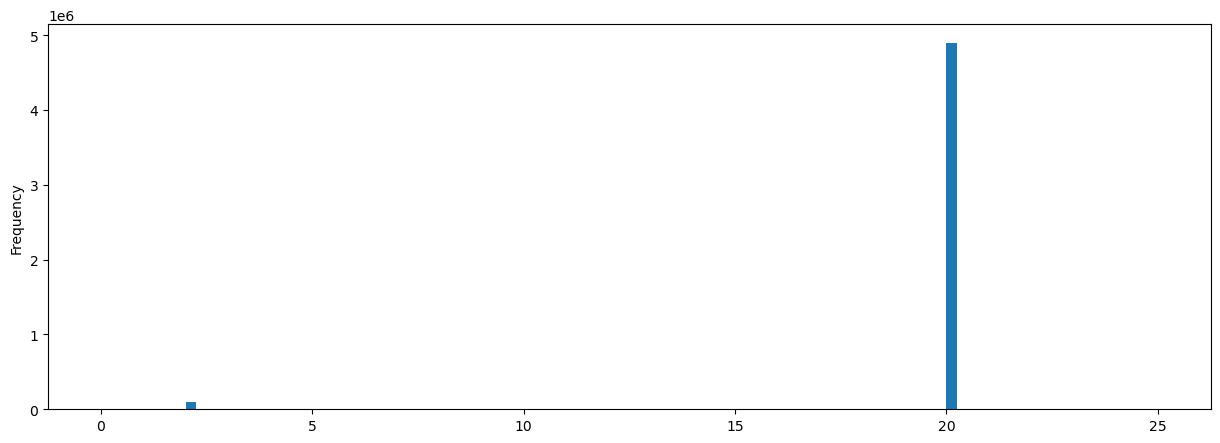

In [66]:
submission_new['num_predictions'].plot(kind='hist', bins=100, range=(0, 25), figsize=(15, 5))

In [71]:
submission_new[submission_new.num_predictions <20]

,session_type,labels,num_predictions
16,12899795_clicks,"[641250, 207754]",2
29,12899808_clicks,"[934396, 1766994]",2
78,12899857_clicks,"[1043508, 764336]",2
104,12899883_clicks,"[1057154, 321817]",2
157,12899936_clicks,"[779699, 1650634]",2
...,...,...,...
5014217,14570390_orders,"[1761561, 410889, 1466434, 632894, 1170149, 1317489, 25357, 1751799, 1643137]",9
5014243,14570416_orders,"[1596508, 192397, 1098690, 817433, 935835, 1411179, 1600033, 1505386, 1735045, 1361359, 119449, 152195, 395217, 716200, 874377, 1488814, 1223673]",17
5015044,14571217_orders,"[1519771, 1390864, 81641, 1436439, 107897, 1104389, 1647277, 950943, 947929, 942114, 668046, 282662]",12
5015300,14571473_orders,"[1437198, 661049, 1181544, 1086072, 1371101]",5


In [48]:
submission_new = submission_new[['session_type', 'labels']]
submission_new['labels'] = submission_new['labels'].apply(lambda x: x[:20])
submission_new.head()

,session_type,labels
0,12899779_clicks,"[59625, 469285, 251302, 1130911, 1657590, 397451, 1493965, 689970, 1491271, 435875, 920960, 737445, 438191, 1340695, 731692, 1253524, 941596, 1790770, 448688, 1667087]"
1,12899780_clicks,"[1142000, 736515, 973453, 582732, 1712906, 209046, 1735169, 1269469, 797055, 1586171, 409620, 889686, 487136, 432989, 346049, 215561, 625301, 1537673, 1758603, 1493044]"
2,12899781_clicks,"[918667, 199008, 194067, 57315, 141736, 1681537, 1628918, 1422724, 374037, 528496, 1836671, 1119163, 1495531, 515373, 600579, 89022, 1228668, 461608, 1102089, 1508281]"
3,12899782_clicks,"[1007613, 595994, 1033148, 834354, 479970, 1696036, 829180, 1669402, 740494, 987399, 889671, 127404, 1711180, 1344773, 229748, 530899, 1072927, 638410, 1099390, 406001]"
4,12899783_clicks,"[1817895, 607638, 1754419, 1216820, 1729553, 300127, 198385, 255297, 1114789, 294573, 351665, 887179, 1420411, 1681696, 230028, 1734579, 379769, 354698, 384776, 1492009]"


#### 2.1.6 Add predictions from Kaggle

In [49]:
submission_kaggle = pd.read_csv(
    "/Users/Artem_Boltaev/Documents/EPAM Projects/7. RecSys_OTTO_Kaggle/source_code/otto_recsys_kaggle/data/interim/submission_OTTO_0.578.csv.gz"
)

In [50]:
submission_kaggle.head()

,session_type,labels
0,14061476_carts,743431 84110 1267119 536718 1236804 1745348 765755 1639042 899855 835881 1738202 35357 872182 110731 942532 508758 206735 1694453 460141 1497238
1,14304314_orders,1739996 891179 946204 134121 1097507 143990 318328 1150072 378454 616986 64529 57540 6168 1262712 335261 106609 1181182 1436160 1520570 10123
2,12936788_orders,1577813 465177 143635 1185385 906045 657062 756470 271928 1718075 1443313 844984 989545 1543088 1345811 1718076 1826732 1851164 533961 657384 1420624
3,13478260_orders,1438170 1410359 341459 1233775 92555 1272539 513463 407061 184463 333998 938013 910960 1800610 63477 663613 375018 41025 840744 1617917 1529045
4,12974731_carts,803928 1080683 1605824 524190 1253913 1101601 104998 1338099 1185084 159789 554660 538483 42628 765745 1116095 1610239 124887 558573 523198 146407


In [51]:
submission_new_kag = submission_new.merge(submission_kaggle, on='session_type', how='left')
submission_new_kag.head()

,session_type,labels_x,labels_y
0,12899779_clicks,"[59625, 469285, 251302, 1130911, 1657590, 397451, 1493965, 689970, 1491271, 435875, 920960, 737445, 438191, 1340695, 731692, 1253524, 941596, 1790770, 448688, 1667087]",1667087 1660089 1138236 967363 742709 620510 339846 199422 1660529 94230 1790770 731692 438191 737445 1253524 59625 225209 3295 485256 986164
1,12899780_clicks,"[1142000, 736515, 973453, 582732, 1712906, 209046, 1735169, 1269469, 797055, 1586171, 409620, 889686, 487136, 432989, 346049, 215561, 625301, 1537673, 1758603, 1493044]",736515 1142000 1537673 973453 1360606 582732 1712906 137088 298280 797055 1515511 897253 493924 747674 1219382 1594869 1738366 1617356 1467222 1057681 515469 976122 605374 1832077 1783127 59625 1724300 1013514 938014 1714898 1246880 950036 975791 180234 914769 380292 1301928 1447078 1307583 1736360 1742451 1550656 1142448 1739065 213851 235568 1046200 1140357 718281 1717949 1348530 981097 624343 1606591 1704504 306013 711993 677063 230425 480578 433190 1807958 1095597 457091 1343486 914928 1617506 1238640 46318 25964 618429 651801 881836 329725 959399 1702657 1333534 409354 67154 416466 1056103 1064014 276267 1359971 1557108 942372 1418100 1726485 1214819 33080 368231 627897 1262947 837691 1140138 1676418 744067 558993 1586694 1751745 578844 1151165 156749 1837097 105393 405527 726428 858933 173187 135309 449160 392015 1305619 129547 1184003 1135200 1820938 247787 1509329 313053 1336393 799666 564363 1743324 899094 1034916 1610884 286989 1702774 1414499 408313 290770 1444213 1207788 905740 1009567 258640 191614 1848427 1383942 1838106 1063368 552652 1171807 1668343 1296039 1707305 974017 905307 725401 131508 1168305 1587768 592959 1851919 1124792 1591497 821698 375610 1839992 151472 340669 1737411 1558394 1202466 845312 1510985 144999 355998 1625839 813668 383214 1062090 1236996 1565443 271254 1388400 338901 1649850 1098765 960097 1004556 912712 981241 1477173 929003 1144895 1768157 1733670 800804 712700 624522 323291 2209 705659 1533519 855511 846336 125597 663333 1580901 701401 1579739 372283 142420 276292 1613910 971272 841461 269021 1170609 852963 1190636 670425 1439279 1548182 1213101 815674 1702651 130719 1176624 1638648 429840 1699474 878127 5999 138431 1251508 258647 1182062 301163 1379999 1551646 413690 678776 1729956 1256317 856046 1725767 669851 874999 621238 476629 151775 972436 1470684 421536 314210 480583 1122023 619885 1521941 1697138 1810463 1365495 784175 225619 1196256 1636805 918665 29528 336350 1728907 673725 1487587 880867 770864 1275298 805...
2,12899781_clicks,"[918667, 199008, 194067, 57315, 141736, 1681537, 1628918, 1422724, 374037, 528496, 1836671, 1119163, 1495531, 515373, 600579, 89022, 1228668, 461608, 1102089, 1508281]",199008 918667 141736 57315 194067 59625 1057681 1739065 1724300 1219382 1594869 1738366 493924 1617356 605374 515469 1783127 1550656 1832077 1467222 897253 976122 1142448 1307583 1742451 950036 1056103 959399 67154 938014 1714898 1246880 975791 1736360 180234 914769 1013514 380292 1447078 213851 747674 457091 1301928 1704504 433190 480578 230425 677063 711993 306013 1606591 1140357 624343 981097 1348530 1717949 718281 905307 1807958 1095597 1046200 881836 408313 409354 1333534 1702657 235568 329725 651801 1343486 618429 25964 46318 1238640 1617506 914928 1135200 416466 1414499 1702774 137088 1712906 298280 1360606 1515511 276267 1359971 1557108 942372 1418100 1726485 1064014 1214819 368231 627897 744067 1537673 558993 726428 1305619 392015 449160 135309 173187 858933 405527 1586694 105393 1837097 156749 1151165 578844 1751745 1262947 837691 1140138 1336393 1207788 1444213 290770 247787 1509329 313053 799666 1009567 564363 1820938 1743324 1034916 1610884 131508 905740 258640 1676418 1296039 129547 33080 1184003 899094 974017 1707305 1668343 191614 1171807 552652 1063368 1838106 1383942 1848427 286989 421536 725401 429840 592959 1851919 1124792 1591497 821698 375610 1839992 151472 340669 1737411 1558394 1202466 845312 1510985 929003 1587768 14

In [52]:
submission_new_kag['labels_y'] = submission_new_kag['labels_y'].apply(lambda x: list(map(int,x.split())))
submission_new_kag.head()

,session_type,labels_x,labels_y
0,12899779_clicks,"[59625, 469285, 251302, 1130911, 1657590, 397451, 1493965, 689970, 1491271, 435875, 920960, 737445, 438191, 1340695, 731692, 1253524, 941596, 1790770, 448688, 1667087]","[1667087, 1660089, 1138236, 967363, 742709, 620510, 339846, 199422, 1660529, 94230, 1790770, 731692, 438191, 737445, 1253524, 59625, 225209, 3295, 485256, 986164]"
1,12899780_clicks,"[1142000, 736515, 973453, 582732, 1712906, 209046, 1735169, 1269469, 797055, 1586171, 409620, 889686, 487136, 432989, 346049, 215561, 625301, 1537673, 1758603, 1493044]","[736515, 1142000, 1537673, 973453, 1360606, 582732, 1712906, 137088, 298280, 797055, 1515511, 897253, 493924, 747674, 1219382, 1594869, 1738366, 1617356, 1467222, 1057681, 515469, 976122, 605374, 1832077, 1783127, 59625, 1724300, 1013514, 938014, 1714898, 1246880, 950036, 975791, 180234, 914769, 380292, 1301928, 1447078, 1307583, 1736360, 1742451, 1550656, 1142448, 1739065, 213851, 235568, 1046200, 1140357, 718281, 1717949, 1348530, 981097, 624343, 1606591, 1704504, 306013, 711993, 677063, 230425, 480578, 433190, 1807958, 1095597, 457091, 1343486, 914928, 1617506, 1238640, 46318, 25964, 618429, 651801, 881836, 329725, 959399, 1702657, 1333534, 409354, 67154, 416466, 1056103, 1064014, 276267, 1359971, 1557108, 942372, 1418100, 1726485, 1214819, 33080, 368231, 627897, 1262947, 837691, 1140138, 1676418, 744067, 558993, 1586694, 1751745, ...]"
2,12899781_clicks,"[918667, 199008, 194067, 57315, 141736, 1681537, 1628918, 1422724, 374037, 528496, 1836671, 1119163, 1495531, 515373, 600579, 89022, 1228668, 461608, 1102089, 1508281]","[199008, 918667, 141736, 57315, 194067, 59625, 1057681, 1739065, 1724300, 1219382, 1594869, 1738366, 493924, 1617356, 605374, 515469, 1783127, 1550656, 1832077, 1467222, 897253, 976122, 1142448, 1307583, 1742451, 950036, 1056103, 959399, 67154, 938014, 1714898, 1246880, 975791, 1736360, 180234, 914769, 1013514, 380292, 1447078, 213851, 747674, 457091, 1301928, 1704504, 433190, 480578, 230425, 677063, 711993, 306013, 1606591, 1140357, 624343, 981097, 1348530, 1717949, 718281, 905307, 1807958, 1095597, 1046200, 881836, 408313, 409354, 1333534, 1702657, 235568, 329725, 651801, 1343486, 618429, 25964, 46318, 1238640, 1617506, 914928, 1135200, 416466, 1414499, 1702774, 137088, 1712906, 298280, 1360606, 1515511, 276267, 1359971, 1557108, 942372, 1418100, 1726485, 1064014, 1214819, 368231, 627897, 744067, 1537673, 558993, 726428, 1305619, ...]"
3,12899782_clicks,"[1007613, 595994, 1033148, 834354, 479970, 1696036, 829180, 1669402, 740494, 987399, 889671, 127404, 1711180, 1344773, 229748, 530899, 1072927, 638410, 1099390, 406001]","[834354, 1033148, 479970, 595994, 1696036, 1007613, 829180, 1669402, 740494, 229748, 975116, 476063, 562753, 530899, 779477, 1072927, 1037537, 638410, 1299062, 987399, 413962, 1099390, 889671, 406001, 723956, 654809, 127404, 1711180, 363336, 794259, 1344773, 1352725, 213851, 1702657, 1333534, 409354, 457091, 1046200, 1301928, 976122, 747674, 605374, 1832077, 1467222, 1057681, 1783127, 897253, 515469, 59625, 1617356, 1550656, 1013514, 380292, 1447078, 1307583, 1736360, 1742451, 1142448, 329725, 1739065, 1724300, 1219382, 1594869, 1738366, 493924, 235568, 711993, 881836, 905307, 1606591, 624343, 981097, 1348530, 1717949, 718281, 286989, 651801, 131508, 725401, 1470684, 421536, 314210, 480583, 1704504, 306013, 180234, 677063, 230425, 480578, 433190, 1807958, 1140357, 1095597, 1343486, 914928, 1617506, 1238640, 46318, 25964, 618429, ...]"
4,12899783_clicks,"[1817895, 607638, 1754419, 1216820, 1729553, 300127, 198385, 255297, 1114789, 294573, 351665, 887179, 1420411, 1681696, 230028, 1734579, 379769, 354698, 384776, 1492009]","[1754419, 607638, 1216820, 59625, 1738366, 1739065, 1724300, 1219382, 1594869, 493924, 1414499, 1617356, 1057681, 515469, 1783127, 605374, 1832077, 1467222, 1142448, 1550656, 1742451, 1736360, 1135200, 1056103, 959399, 67154, 938014, 1714898, 1246880, 950036, 975791, 180234, 914769, 1013514, 380292, 14470

In [53]:
submission_new_kag["labels"] = submission_new_kag.apply(
    lambda row: [
        *row.labels_x,
        *row.labels_y,
    ],
    axis=1,
)
submission_new_kag.head()

,session_type,labels_x,labels_y,labels
0,12899779_clicks,"[59625, 469285, 251302, 1130911, 1657590, 397451, 1493965, 689970, 1491271, 435875, 920960, 737445, 438191, 1340695, 731692, 1253524, 941596, 1790770, 448688, 1667087]","[1667087, 1660089, 1138236, 967363, 742709, 620510, 339846, 199422, 1660529, 94230, 1790770, 731692, 438191, 737445, 1253524, 59625, 225209, 3295, 485256, 986164]","[59625, 469285, 251302, 1130911, 1657590, 397451, 1493965, 689970, 1491271, 435875, 920960, 737445, 438191, 1340695, 731692, 1253524, 941596, 1790770, 448688, 1667087, 1667087, 1660089, 1138236, 967363, 742709, 620510, 339846, 199422, 1660529, 94230, 1790770, 731692, 438191, 737445, 1253524, 59625, 225209, 3295, 485256, 986164]"
1,12899780_clicks,"[1142000, 736515, 973453, 582732, 1712906, 209046, 1735169, 1269469, 797055, 1586171, 409620, 889686, 487136, 432989, 346049, 215561, 625301, 1537673, 1758603, 1493044]","[736515, 1142000, 1537673, 973453, 1360606, 582732, 1712906, 137088, 298280, 797055, 1515511, 897253, 493924, 747674, 1219382, 1594869, 1738366, 1617356, 1467222, 1057681, 515469, 976122, 605374, 1832077, 1783127, 59625, 1724300, 1013514, 938014, 1714898, 1246880, 950036, 975791, 180234, 914769, 380292, 1301928, 1447078, 1307583, 1736360, 1742451, 1550656, 1142448, 1739065, 213851, 235568, 1046200, 1140357, 718281, 1717949, 1348530, 981097, 624343, 1606591, 1704504, 306013, 711993, 677063, 230425, 480578, 433190, 1807958, 1095597, 457091, 1343486, 914928, 1617506, 1238640, 46318, 25964, 618429, 651801, 881836, 329725, 959399, 1702657, 1333534, 409354, 67154, 416466, 1056103, 1064014, 276267, 1359971, 1557108, 942372, 1418100, 1726485, 1214819, 33080, 368231, 627897, 1262947, 837691, 1140138, 1676418, 744067, 558993, 1586694, 1751745, ...]","[1142000, 736515, 973453, 582732, 1712906, 209046, 1735169, 1269469, 797055, 1586171, 409620, 889686, 487136, 432989, 346049, 215561, 625301, 1537673, 1758603, 1493044, 736515, 1142000, 1537673, 973453, 1360606, 582732, 1712906, 137088, 298280, 797055, 1515511, 897253, 493924, 747674, 1219382, 1594869, 1738366, 1617356, 1467222, 1057681, 515469, 976122, 605374, 1832077, 1783127, 59625, 1724300, 1013514, 938014, 1714898, 1246880, 950036, 975791, 180234, 914769, 380292, 1301928, 1447078, 1307583, 1736360, 1742451, 1550656, 1142448, 1739065, 213851, 235568, 1046200, 1140357, 718281, 1717949, 1348530, 981097, 624343, 1606591, 1704504, 306013, 711993, 677063, 230425, 480578, 433190, 1807958, 1095597, 457091, 1343486, 914928, 1617506, 1238640, 46318, 25964, 618429, 651801, 881836, 329725, 959399, 1702657, 1333534, 409354, 67154, 416466, ...]"
2,12899781_clicks,"[918667, 199008, 194067, 57315, 141736, 1681537, 1628918, 1422724, 374037, 528496, 1836671, 1119163, 1495531, 515373, 600579, 89022, 1228668, 461608, 1102089, 1508281]","[199008, 918667, 141736, 57315, 194067, 59625, 1057681, 1739065, 1724300, 1219382, 1594869, 1738366, 493924, 1617356, 605374, 515469, 1783127, 1550656, 1832077, 1467222, 897253, 976122, 1142448, 1307583, 1742451, 950036, 1056103, 959399, 67154, 938014, 1714898, 1246880, 975791, 1736360, 180234, 914769, 1013514, 380292, 1447078, 213851, 747674, 457091, 1301928, 1704504, 433190, 480578, 230425, 677063, 711993, 306013, 1606591, 1140357, 624343, 981097, 1348530, 1717949, 718281, 905307, 1807958, 1095597, 1046200, 881836, 408313, 409354, 1333534, 1702657, 235568, 329725, 651801, 1343486, 618429, 25964, 46318, 1238640, 1617506, 914928, 1135200, 416466, 1414499, 1702774, 137088, 1712906, 298280, 1360606, 1515511, 276267, 1359971, 1557108, 942372, 1418100, 1726485, 1064014, 1214819, 368231, 627897, 744067, 1537673, 558993, 726428, 1305619, ...]","[918667, 199008, 194067, 57315, 141736, 1681537, 1628918, 1422724, 374037, 528496, 1836671, 1119163, 1495531, 515373, 600579, 89022, 1228668, 461608, 1102089, 1508281, 199008, 918667, 141736, 57315, 194067, 59625, 1057681, 1739065, 1724300, 1219382, 1594869, 1738366, 493924, 1617356, 605374, 515469, 1783127, 1550656, 1832077, 1467222, 897253,

In [54]:
# drop duplicates predictions
submission_new_kag["labels"] = submission_new_kag[
    "labels"
].apply(lambda x: list(dict.fromkeys(x)))

submission_new_kag.head()

,session_type,labels_x,labels_y,labels
0,12899779_clicks,"[59625, 469285, 251302, 1130911, 1657590, 397451, 1493965, 689970, 1491271, 435875, 920960, 737445, 438191, 1340695, 731692, 1253524, 941596, 1790770, 448688, 1667087]","[1667087, 1660089, 1138236, 967363, 742709, 620510, 339846, 199422, 1660529, 94230, 1790770, 731692, 438191, 737445, 1253524, 59625, 225209, 3295, 485256, 986164]","[59625, 469285, 251302, 1130911, 1657590, 397451, 1493965, 689970, 1491271, 435875, 920960, 737445, 438191, 1340695, 731692, 1253524, 941596, 1790770, 448688, 1667087, 1660089, 1138236, 967363, 742709, 620510, 339846, 199422, 1660529, 94230, 225209, 3295, 485256, 986164]"
1,12899780_clicks,"[1142000, 736515, 973453, 582732, 1712906, 209046, 1735169, 1269469, 797055, 1586171, 409620, 889686, 487136, 432989, 346049, 215561, 625301, 1537673, 1758603, 1493044]","[736515, 1142000, 1537673, 973453, 1360606, 582732, 1712906, 137088, 298280, 797055, 1515511, 897253, 493924, 747674, 1219382, 1594869, 1738366, 1617356, 1467222, 1057681, 515469, 976122, 605374, 1832077, 1783127, 59625, 1724300, 1013514, 938014, 1714898, 1246880, 950036, 975791, 180234, 914769, 380292, 1301928, 1447078, 1307583, 1736360, 1742451, 1550656, 1142448, 1739065, 213851, 235568, 1046200, 1140357, 718281, 1717949, 1348530, 981097, 624343, 1606591, 1704504, 306013, 711993, 677063, 230425, 480578, 433190, 1807958, 1095597, 457091, 1343486, 914928, 1617506, 1238640, 46318, 25964, 618429, 651801, 881836, 329725, 959399, 1702657, 1333534, 409354, 67154, 416466, 1056103, 1064014, 276267, 1359971, 1557108, 942372, 1418100, 1726485, 1214819, 33080, 368231, 627897, 1262947, 837691, 1140138, 1676418, 744067, 558993, 1586694, 1751745, ...]","[1142000, 736515, 973453, 582732, 1712906, 209046, 1735169, 1269469, 797055, 1586171, 409620, 889686, 487136, 432989, 346049, 215561, 625301, 1537673, 1758603, 1493044, 1360606, 137088, 298280, 1515511, 897253, 493924, 747674, 1219382, 1594869, 1738366, 1617356, 1467222, 1057681, 515469, 976122, 605374, 1832077, 1783127, 59625, 1724300, 1013514, 938014, 1714898, 1246880, 950036, 975791, 180234, 914769, 380292, 1301928, 1447078, 1307583, 1736360, 1742451, 1550656, 1142448, 1739065, 213851, 235568, 1046200, 1140357, 718281, 1717949, 1348530, 981097, 624343, 1606591, 1704504, 306013, 711993, 677063, 230425, 480578, 433190, 1807958, 1095597, 457091, 1343486, 914928, 1617506, 1238640, 46318, 25964, 618429, 651801, 881836, 329725, 959399, 1702657, 1333534, 409354, 67154, 416466, 1056103, 1064014, 276267, 1359971, 1557108, 942372, 1418100, ...]"
2,12899781_clicks,"[918667, 199008, 194067, 57315, 141736, 1681537, 1628918, 1422724, 374037, 528496, 1836671, 1119163, 1495531, 515373, 600579, 89022, 1228668, 461608, 1102089, 1508281]","[199008, 918667, 141736, 57315, 194067, 59625, 1057681, 1739065, 1724300, 1219382, 1594869, 1738366, 493924, 1617356, 605374, 515469, 1783127, 1550656, 1832077, 1467222, 897253, 976122, 1142448, 1307583, 1742451, 950036, 1056103, 959399, 67154, 938014, 1714898, 1246880, 975791, 1736360, 180234, 914769, 1013514, 380292, 1447078, 213851, 747674, 457091, 1301928, 1704504, 433190, 480578, 230425, 677063, 711993, 306013, 1606591, 1140357, 624343, 981097, 1348530, 1717949, 718281, 905307, 1807958, 1095597, 1046200, 881836, 408313, 409354, 1333534, 1702657, 235568, 329725, 651801, 1343486, 618429, 25964, 46318, 1238640, 1617506, 914928, 1135200, 416466, 1414499, 1702774, 137088, 1712906, 298280, 1360606, 1515511, 276267, 1359971, 1557108, 942372, 1418100, 1726485, 1064014, 1214819, 368231, 627897, 744067, 1537673, 558993, 726428, 1305619, ...]","[918667, 199008, 194067, 57315, 141736, 1681537, 1628918, 1422724, 374037, 528496, 1836671, 1119163, 1495531, 515373, 600579, 89022, 1228668, 461608, 1102089, 1508281, 59625, 1057681, 1739065, 1724300, 1219382, 1594869, 1738366, 493924, 1617356, 605374, 515469, 1783127, 1550656, 1832077, 1467222, 897253, 976122, 1142448, 1307583, 1742451, 950036, 1056103, 959399, 67154, 938014, 1714898, 1246880, 9

In [55]:
submission_new_kag['num_predictions'] = submission_new_kag['labels'].apply(lambda x: len(x))

<AxesSubplot:ylabel='Frequency'>

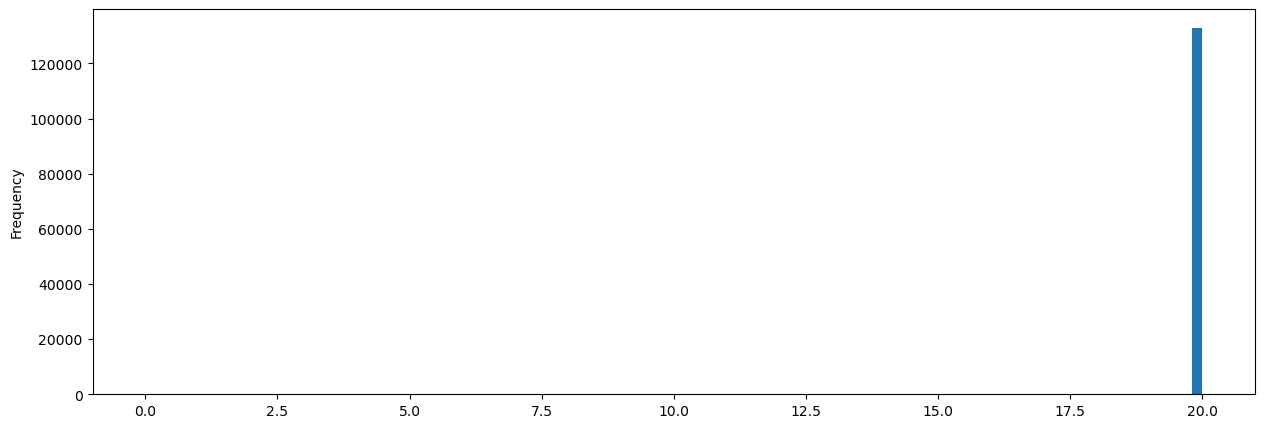

In [56]:
submission_new_kag['num_predictions'].plot(kind='hist', bins=100, range=(0, 20), figsize=(15, 5))

In [57]:
submission_new_kag[submission_new_kag.num_predictions < 18]

,session_type,labels_x,labels_y,labels,num_predictions
731186,13630965_clicks,"[1319982, 531370, 858154, 1221975, 575616, 1378668]","[1551213, 1551213, 485256, 485256, 858154, 531370, 1221975, 1551213, 1551213, 485256, 485256, 1553599, 1247806, 1120017, 256827, 1319982, 33343, 579690, 832192, 554660]","[1319982, 531370, 858154, 1221975, 575616, 1378668, 1551213, 485256, 1553599, 1247806, 1120017, 256827, 33343, 579690, 832192, 554660]",16


In [58]:
submission_new_kag = submission_new_kag[['session_type', 'labels']]
submission_new_kag['labels'] = submission_new_kag['labels'].apply(lambda x: x[:20])
submission_new_kag.head()

,session_type,labels
0,12899779_clicks,"[59625, 469285, 251302, 1130911, 1657590, 397451, 1493965, 689970, 1491271, 435875, 920960, 737445, 438191, 1340695, 731692, 1253524, 941596, 1790770, 448688, 1667087]"
1,12899780_clicks,"[1142000, 736515, 973453, 582732, 1712906, 209046, 1735169, 1269469, 797055, 1586171, 409620, 889686, 487136, 432989, 346049, 215561, 625301, 1537673, 1758603, 1493044]"
2,12899781_clicks,"[918667, 199008, 194067, 57315, 141736, 1681537, 1628918, 1422724, 374037, 528496, 1836671, 1119163, 1495531, 515373, 600579, 89022, 1228668, 461608, 1102089, 1508281]"
3,12899782_clicks,"[1007613, 595994, 1033148, 834354, 479970, 1696036, 829180, 1669402, 740494, 987399, 889671, 127404, 1711180, 1344773, 229748, 530899, 1072927, 638410, 1099390, 406001]"
4,12899783_clicks,"[1817895, 607638, 1754419, 1216820, 1729553, 300127, 198385, 255297, 1114789, 294573, 351665, 887179, 1420411, 1681696, 230028, 1734579, 379769, 354698, 384776, 1492009]"


#### 2.1.7 Write file to submission

In [59]:
submission_new_kag_final = submission_new_kag[['session_type', 'labels']]

In [60]:
#drop some simbols
submission_new_kag_final['labels'] = submission_new_kag_final['labels'].apply(lambda x: str(x))

submission_new_kag_final['labels'] = submission_new_kag_final['labels'].apply(lambda x: x.replace('[', ''))
submission_new_kag_final['labels'] = submission_new_kag_final['labels'].apply(lambda x: x.replace(']', ''))
submission_new_kag_final['labels'] = submission_new_kag_final['labels'].apply(lambda x: x.replace(',', ''))
submission_new_kag_final['labels'] = submission_new_kag_final['labels'].apply(lambda x: x.replace("\n", ''))
submission_new_kag_final['labels'] = submission_new_kag_final['labels'].apply(lambda x: x.lstrip())
submission_new_kag_final['labels'] = submission_new_kag_final['labels'].apply(lambda x: x.replace('  ', ' '))
submission_new_kag_final.head()

,session_type,labels
0,12899779_clicks,59625 469285 251302 1130911 1657590 397451 1493965 689970 1491271 435875 920960 737445 438191 1340695 731692 1253524 941596 1790770 448688 1667087
1,12899780_clicks,1142000 736515 973453 582732 1712906 209046 1735169 1269469 797055 1586171 409620 889686 487136 432989 346049 215561 625301 1537673 1758603 1493044
2,12899781_clicks,918667 199008 194067 57315 141736 1681537 1628918 1422724 374037 528496 1836671 1119163 1495531 515373 600579 89022 1228668 461608 1102089 1508281
3,12899782_clicks,1007613 595994 1033148 834354 479970 1696036 829180 1669402 740494 987399 889671 127404 1711180 1344773 229748 530899 1072927 638410 1099390 406001
4,12899783_clicks,1817895 607638 1754419 1216820 1729553 300127 198385 255297 1114789 294573 351665 887179 1420411 1681696 230028 1734579 379769 354698 384776 1492009


In [61]:
submission_new_kag_final[['session_type', 'labels']].to_csv('/Users/Artem_Boltaev/Documents/EPAM Projects/7. RecSys_OTTO_Kaggle/source_code/otto_recsys_kaggle/models/session-rec/results/next/OTTO/submission_OTTO_V8.csv.gz', index=False, compression="gzip", sep=",")